In [2]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
from imblearn.over_sampling import SMOTE

In [3]:
# load data
df = pd.read_excel("../data/raw/Telco_customer_churn_adapted_v2.xlsx")
df_ori = df.copy()

In [4]:
df_ori.describe().T

,count,mean,std,min,25%,50%,75%,max
Customer ID,7043.0,3521.000000,2033.283305,0.000000,1760.500000,3521.000000,5281.50000,7042.00000
Tenure Months,7043.0,32.371149,24.559481,0.000000,9.000000,29.000000,55.00000,72.00000
Monthly Purchase (Thou. IDR),7043.0,84.190200,39.117061,23.725000,46.150000,91.455000,116.80500,154.37500
Longitude,7043.0,107.043246,0.358316,106.816666,106.816666,106.816666,107.60981,107.60981
Latitude,7043.0,-6.404184,0.322898,-6.914744,-6.914744,-6.200000,-6.20000,-6.20000
CLTV (Predicted Thou. IDR),7043.0,5720.384481,1537.974298,2603.900000,4509.700000,5885.100000,6994.65000,8450.00000


In [5]:
df_ori.describe(exclude="number").T

,count,unique,top,freq
Location,7043,2,Jakarta,5031
Device Class,7043,3,High End,3096
Games Product,7043,3,No,3498
Music Product,7043,3,No,3088
Education Product,7043,3,No,3095
Call Center,7043,2,No,4999
Video Product,7043,3,No,2810
Use MyApp,7043,3,No,2785
Payment Method,7043,4,Pulsa,2365
Churn Label,7043,2,No,5174


# Background

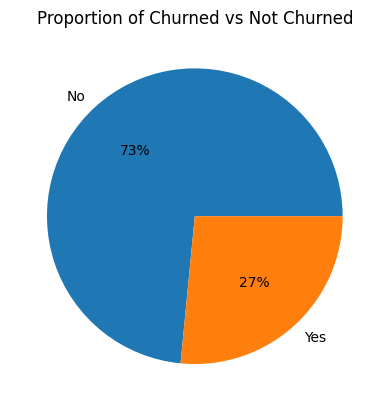

In [5]:
plot_df = df['Churn Label'].value_counts(normalize=True)*100
plt.pie(plot_df, labels=plot_df.index, autopct='%.0f%%')
plt.title("Proportion of Churned vs Not Churned")
plt.show()

27% of passengers churned from purchasing

In [6]:
display(df.groupby("Churn Label")["CLTV (Predicted Thou. IDR)"].sum())
display(df.groupby("Churn Label")["Monthly Purchase (Thou. IDR)"].sum())

Churn Label
No     30206835.1
Yes    10081832.8
Name: CLTV (Predicted Thou. IDR), dtype: float64

Churn Label
No     412081.475
Yes    180870.105
Name: Monthly Purchase (Thou. IDR), dtype: float64

Around `Rp10,081,832,800.00` potential income in the future gone.

Around `Rp180,870,800.00` stripped out from the company's monthly income.

# EDA

## Univariate

### Original

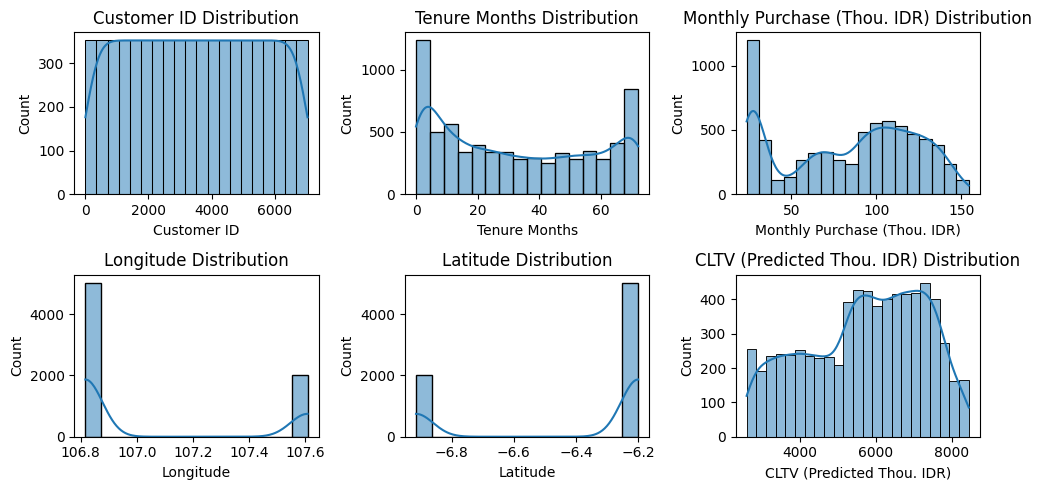

In [7]:
numerical_columns = df.select_dtypes(include=[int, float]).columns
fig, ax = plt.subplots(nrows=int(len(numerical_columns)//3), ncols=3, figsize=(10, 5))

i = 0 # for accessing array of column names
for rows in ax: # access rows of subplots
    for col in rows: # access column inside subplot rows
        sns.histplot(data=df, x=numerical_columns[i], kde=True, ax=col)
        col.set_title(f"{numerical_columns[i]} Distribution")
        i+=1
fig.tight_layout()

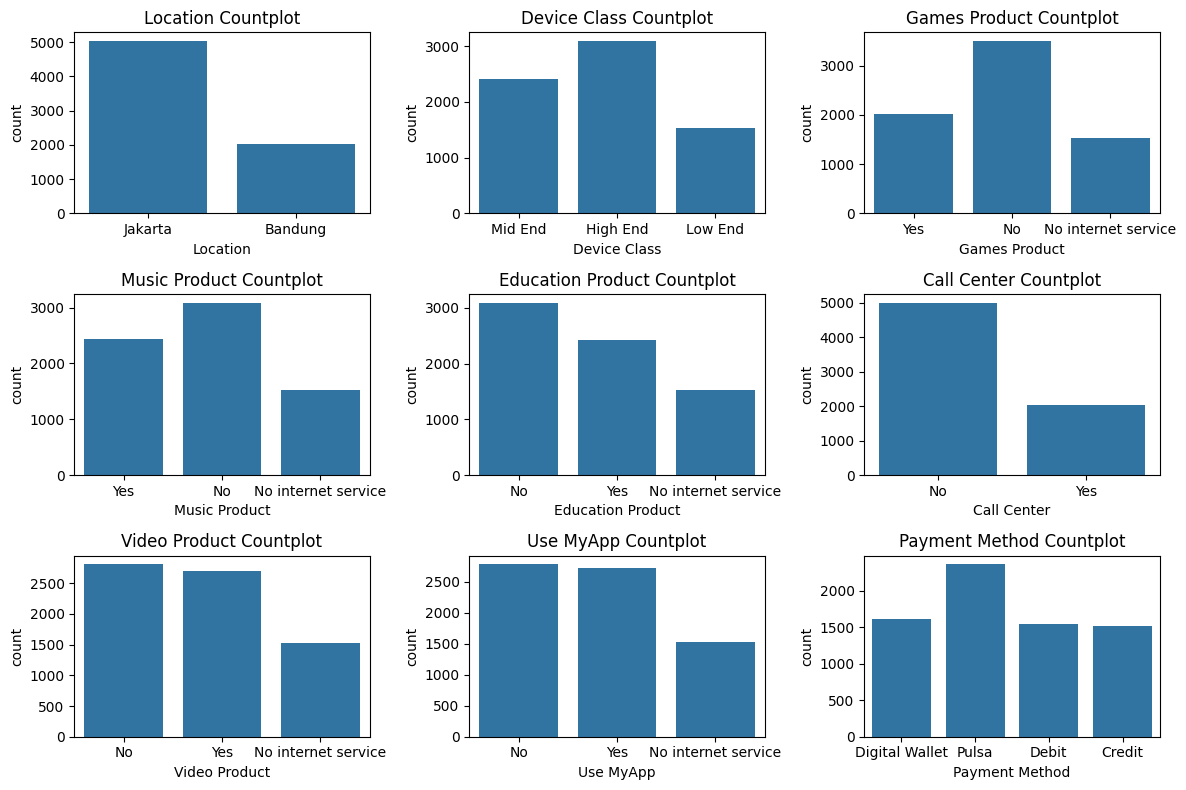

In [8]:
numerical_columns = df.select_dtypes(include=[object]).columns
fig, ax = plt.subplots(nrows=int(len(numerical_columns)//3), ncols=3, figsize=(12, 8))

i = 0 # for accessing array of column names
for rows in ax: # access rows of subplots
    for col in rows: # access column inside subplot rows
        sns.countplot(data=df,x=numerical_columns[i], ax=col)
        col.set_title(f"{numerical_columns[i]} Countplot")
        i+=1
fig.tight_layout()

### Hue `Churn Label`

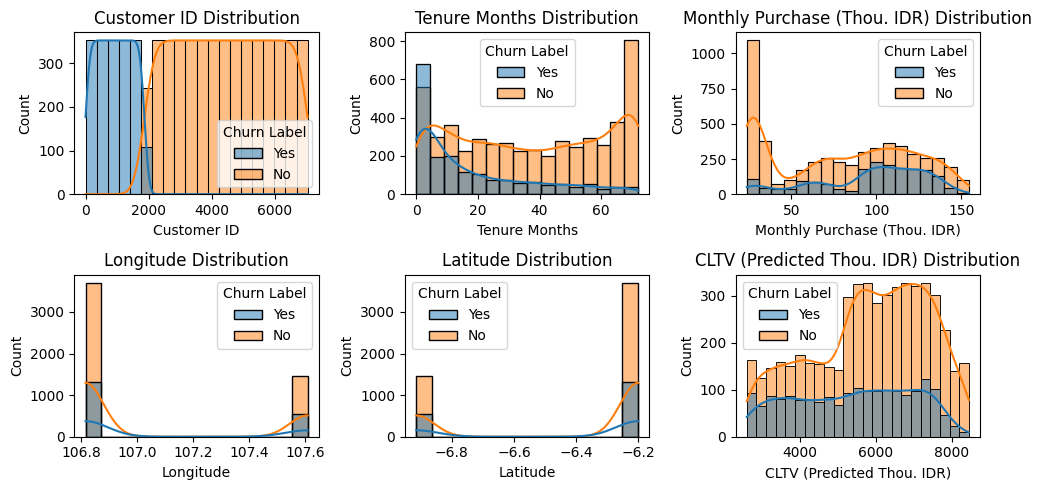

In [9]:
numerical_columns = df.select_dtypes(include=[int, float]).columns
fig, ax = plt.subplots(nrows=int(len(numerical_columns)//3), ncols=3, figsize=(10, 5))

i = 0 # for accessing array of column names
for rows in ax: # access rows of subplots
    for col in rows: # access column inside subplot rows
        sns.histplot(data=df, x=numerical_columns[i], hue="Churn Label", kde=True, ax=col)
        col.set_title(f"{numerical_columns[i]} Distribution")
        i+=1
fig.tight_layout()

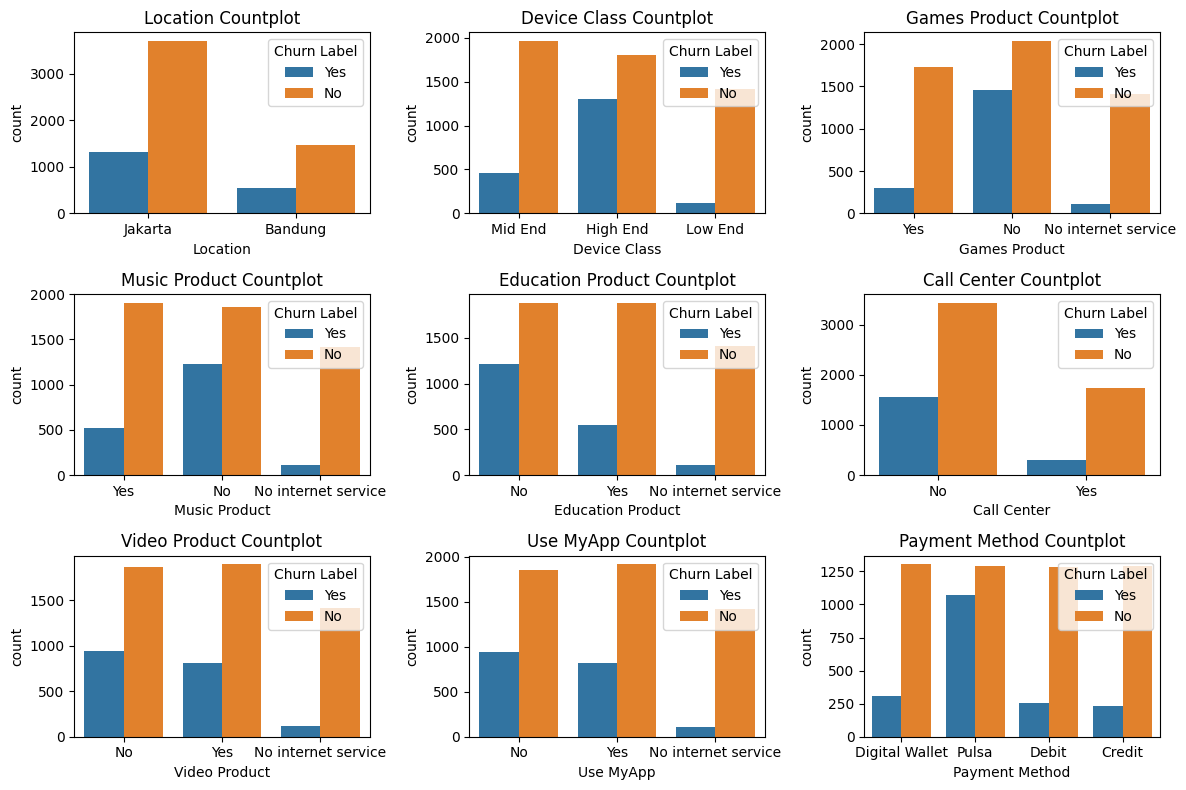

In [10]:
numerical_columns = df.select_dtypes(include=[object]).columns
fig, ax = plt.subplots(nrows=int(len(numerical_columns)//3), ncols=3, figsize=(12, 8))

i = 0 # for accessing array of column names
for rows in ax: # access rows of subplots
    for col in rows: # access column inside subplot rows
        sns.countplot(data=df,x=numerical_columns[i], hue='Churn Label', ax=col)
        col.set_title(f"{numerical_columns[i]} Countplot")
        i+=1
fig.tight_layout()

### Skew

In [11]:
numerical_columns = df.select_dtypes(include=[int, float]).columns
for col in numerical_columns:
    skewness = df[col].skew()
    if skewness < -0.5: 
        print(f"{col}, skewness: {skewness}, left skewed")
    elif skewness > 0.5: 
        print(f"{col}, skewness: {skewness}, right skewed")
    else: 
        print(f"{col}, skewness: {skewness}, approximately symmetric")

Customer ID, skewness: 0.0, approximately symmetric
Tenure Months, skewness: 0.2395397495619829, approximately symmetric
Monthly Purchase (Thou. IDR), skewness: -0.2205244339439807, approximately symmetric
Longitude, skewness: 0.9491054700666193, right skewed
Latitude, skewness: -0.9491054700664001, left skewed
CLTV (Predicted Thou. IDR), skewness: -0.3116021004049805, approximately symmetric


### Kurtosis

In [12]:
numerical_columns = df.select_dtypes(include=[int, float]).columns
for col in numerical_columns:
    kurtosis = df[col].kurtosis()
    if kurtosis > 3:
        print(f"{col}, kurtosis: {kurtosis}, leptokurtic (heavy tailed, more chance of outliers)")
    elif kurtosis < 3:
        print(f"{col}, kurtosis: {kurtosis}, platykurtic")
    else:
        print(f"{col}, kurtosis: {kurtosis}, mesokurtic")

Customer ID, kurtosis: -1.1999999999999997, platykurtic
Tenure Months, kurtosis: -1.3873716359716848, platykurtic
Monthly Purchase (Thou. IDR), kurtosis: -1.2572596945495054, platykurtic
Longitude, kurtosis: -1.099511115413302, platykurtic
Latitude, kurtosis: -1.0995111154135797, platykurtic
CLTV (Predicted Thou. IDR), kurtosis: -0.9340324830072797, platykurtic


## Device Class

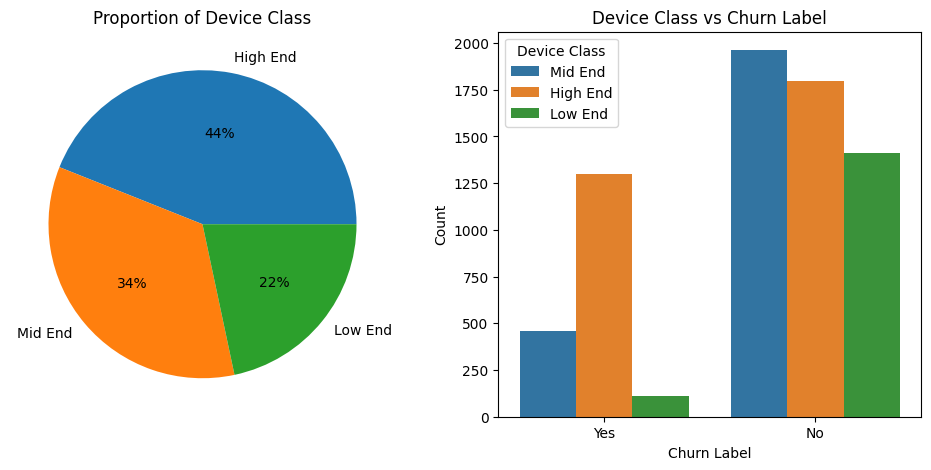

In [13]:
fig, ax = plt.subplots(figsize=(12, 5), ncols=2)

# Proportion of the Device Class
# =================================================================
plot_df = df["Device Class"].value_counts(normalize=True) * 100
ax[0].pie(plot_df, labels=plot_df.index, autopct="%.0f%%")
ax[0].set_title("Proportion of Device Class")

# Device Class vs Churn Label
# =================================================================
sns.countplot(data=df, x='Churn Label', hue='Device Class', ax=ax[1])
ax[1].set(xlabel = "Churn Label", ylabel="Count", title="Device Class vs Churn Label")
plt.show()

1. `~1250` customer who churned are from the high end class followed by mid (`~500`) and low (`~125`) end class. From this data higher end devices resulted in more likely to churn.
2. The proportion is dominated by **High End**, followed by **Mid End** and **Low End**

## Location

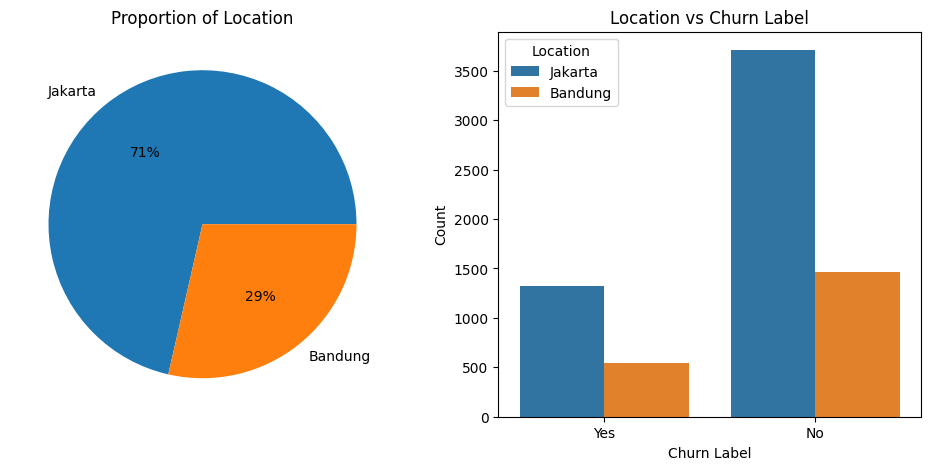

In [14]:
fig, ax = plt.subplots(figsize=(12, 5), ncols=2)

# Proportion of the Location
# =================================================================
plot_df = df["Location"].value_counts(normalize=True) * 100
ax[0].pie(plot_df, labels=plot_df.index, autopct="%.0f%%")
ax[0].set_title("Proportion of Location")

# Location vs Churn Label
# =================================================================
sns.countplot(data=df, x='Churn Label', hue='Location', ax=ax[1])
ax[1].set(xlabel = "Churn Label", ylabel="Count", title="Location vs Churn Label")
plt.show()

In [15]:
location_churn = df.pivot_table(values="Customer ID", index="Churn Label", columns="Location", aggfunc="count", margins=True)
location_churn / location_churn.loc["All", :]

Location,Bandung,Jakarta,All
Churn Label,,,
No,0.728628,0.73703,0.73463
Yes,0.271372,0.26297,0.26537
All,1.000000,1.00000,1.00000


1. Jakarta has the highes churn rate, but It's due to inequality of proportion between users from **Jakarta** and **Bandung**
2. The changes of user either from `Bandung` and `Jakarta` are almost the same. 

## Games Product, Music Product, Education Product, Video Product, and Use MyApp
`No internet service` and `No` means the same thing which is the use doesn't use the internet for the specified **product** or **app**.

In [16]:
# change label of product and app
def preprocess_data(df):
    def check_internet_service(row): 
        if row['Games Product'] == "No internet service"\
            and row['Music Product'] == "No internet service"\
            and row['Education Product'] == "No internet service"\
            and row['Video Product'] == "No internet service"\
            and row['Use MyApp'] == "No internet service":
            return 0
        else: return 1
    
    df=df.copy()
    df['Internet Service'] = df.apply(lambda x: check_internet_service(x), axis=1)
    
    # prod_app_map = {
    #     "Yes": 1,
    #     "No": 0,
    #     "No internet service": 0,
    # }
    # df['Games Product'] = df['Games Product'].replace(prod_app_map)
    # df['Music Product'] = df['Music Product'].replace(prod_app_map)
    # df['Education Product'] = df['Education Product'].replace(prod_app_map)
    # df['Video Product'] = df['Video Product'].replace(prod_app_map)
    # df['Use MyApp'] = df['Use MyApp'].replace(prod_app_map)

    df['Churn'] = df['Churn Label'].map({"Yes": "1", "No": "0"}).astype(int)    
    df['Total Purchase'] = df['Tenure Months'] * df['Monthly Purchase (Thou. IDR)']
    return df

df = preprocess_data(df_ori)

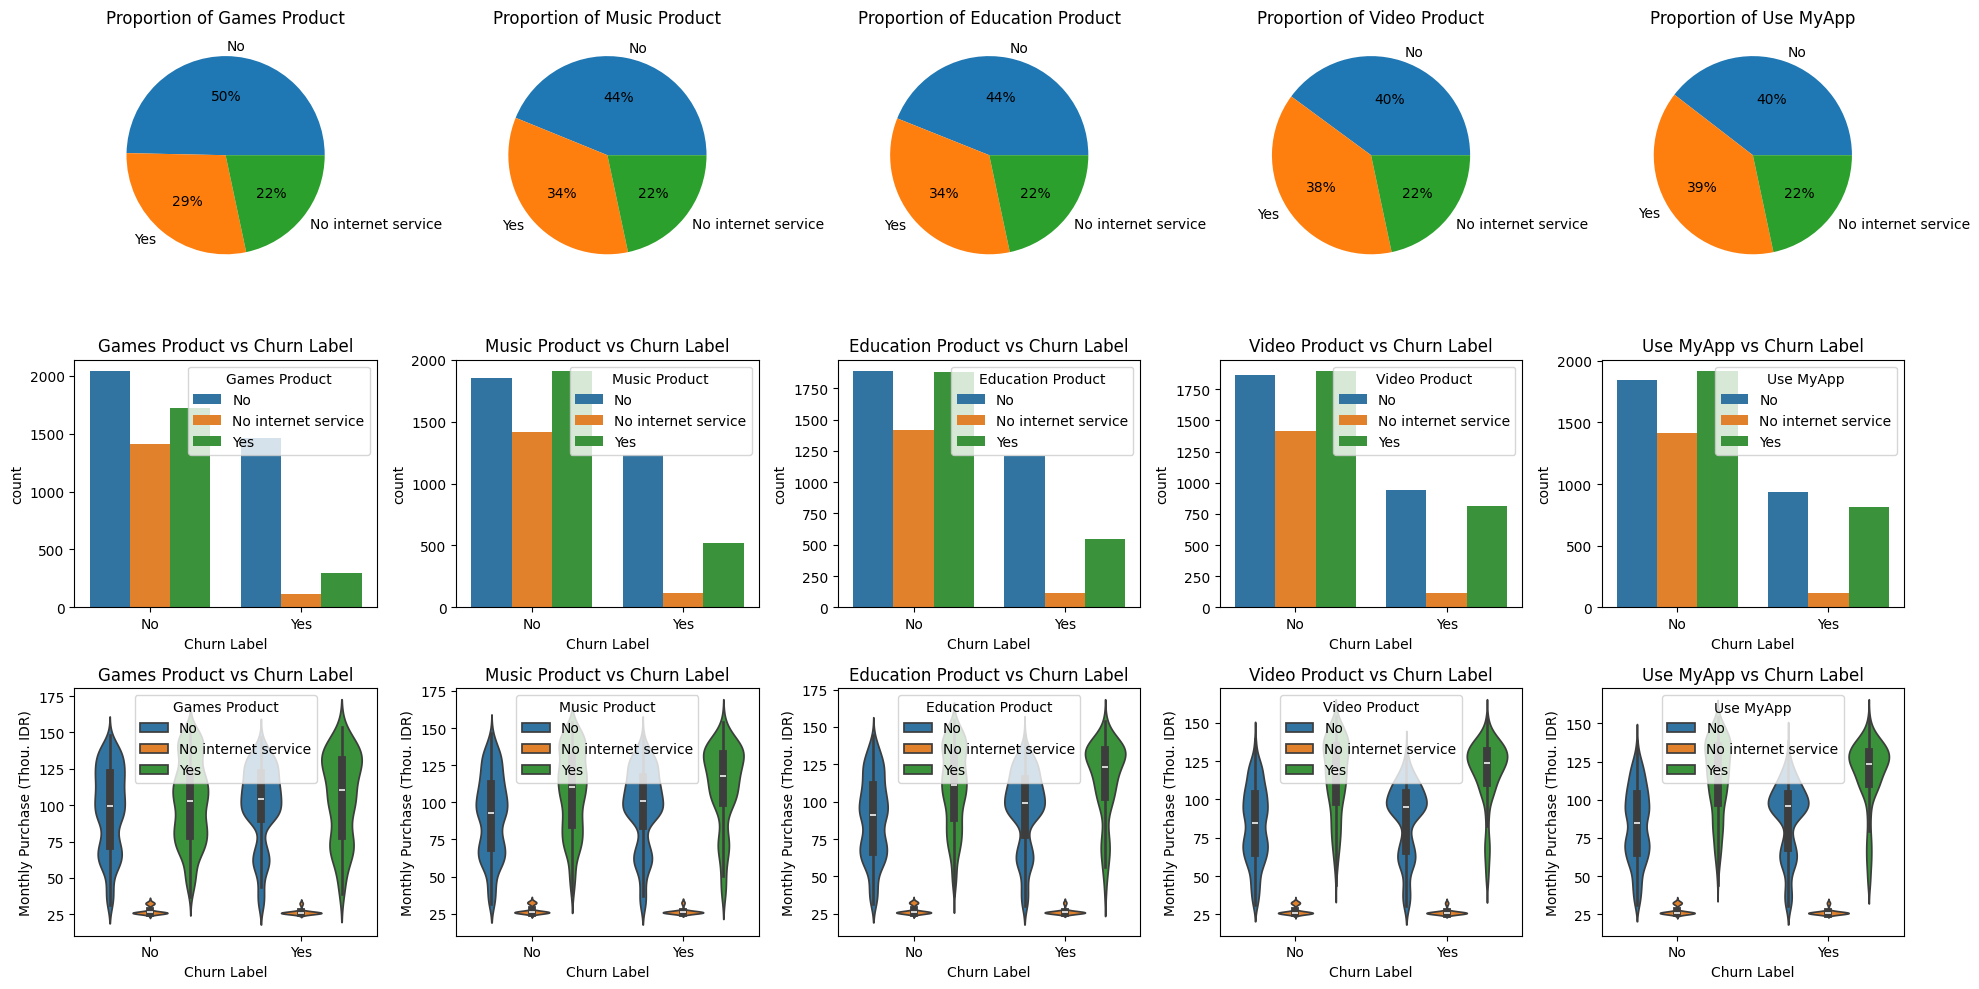

In [17]:

cols = ["Games Product", "Music Product", "Education Product", "Video Product", "Use MyApp"]
fig, ax = plt.subplots(nrows=3, ncols=len(cols), figsize=(20, 10))

for i, c in enumerate(cols):
    plot_df = df[c].value_counts(normalize=True) * 100
    ax[0][i].pie(plot_df, labels=plot_df.index, autopct="%.0f%%")
    ax[0][i].set_title(f"Proportion of {c}")
    

for i, c in enumerate(cols):
    sns.countplot(data=df.sort_values(by=[c, 'Churn Label']), x='Churn Label', hue=c, ax=ax[1][i])
    ax[1][i].set_title(f"{c} vs Churn Label")
    
    
for i, c in enumerate(cols):
    sns.violinplot(data=df.sort_values(by=[c, 'Churn Label']), x='Churn Label', y="Monthly Purchase (Thou. IDR)", hue=c, ax=ax[2][i])
    ax[2][i].set_title(f"{c} vs Churn Label")

fig.tight_layout()

1. People who didn't use internet service for Games, Music, and Education Product has a higher change of churn.
2. People who's monthly purchase is around **100K** and didn't use the internet service for any of the products has more change of churning
3. People who's monthly purchase is around **125K** and didn't use the internet service for any of the products has more change of churning

Users who churned they don't use the internet service for accessing those products

## Payment Method

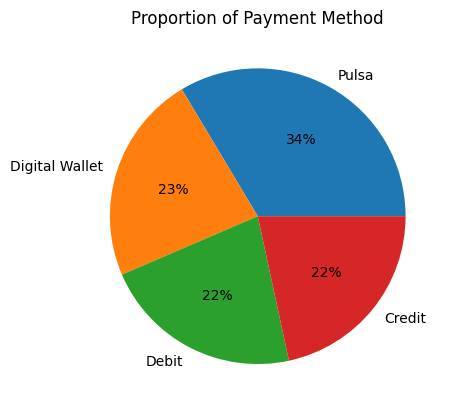

In [18]:
plot_df = df["Payment Method"].value_counts(normalize=True) * 100
plt.pie(plot_df, labels=plot_df.index, autopct="%.0f%%")
plt.title(f"Proportion of Payment Method")
plt.show()

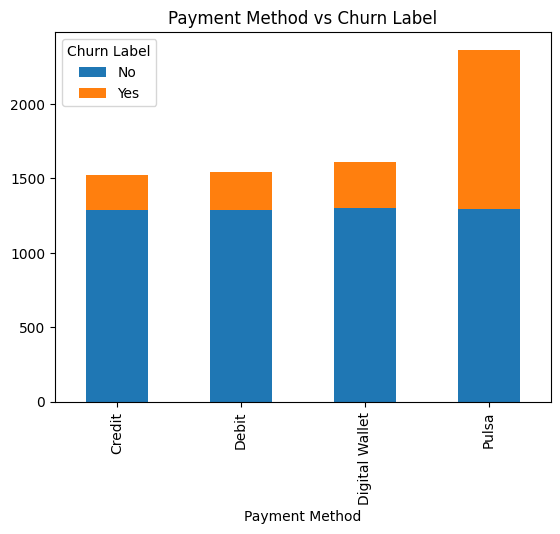

In [19]:
plot_df = df.pivot_table(index="Payment Method", columns="Churn Label", values="Customer ID", aggfunc="count")
plot_df.plot(kind="bar", stacked=True)
plt.title("Payment Method vs Churn Label")
plt.show()

In [20]:
churn_payment_method = df.pivot_table(index="Payment Method", columns="Churn", values="Customer ID", aggfunc="count", margins=True)
churn_payment_method /= churn_payment_method.loc['All', :]
churn_payment_method = churn_payment_method.loc[churn_payment_method.index != 'All', churn_payment_method.columns != 'All']
churn_payment_method

Churn,0,1
Payment Method,,
Credit,0.249324,0.124131
Debit,0.248550,0.138042
Digital Wallet,0.252029,0.164794
Pulsa,0.250097,0.573034


1. Users buy using pulsa has high change of churn

## Tenure Months

In [21]:
df.pivot_table(index="Churn", values="Tenure Months", aggfunc="mean")

,Tenure Months
Churn,
0,37.569965
1,17.979133


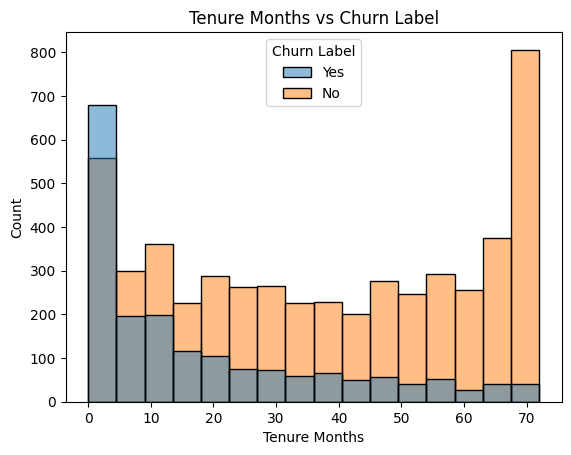

In [22]:
sns.histplot(data=df, x='Tenure Months', hue='Churn Label')
plt.title("Tenure Months vs Churn Label")
plt.show()

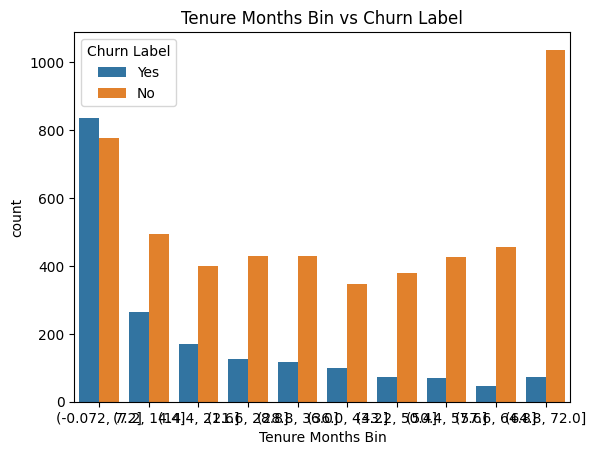

In [23]:
df['Tenure Months Bin'] = pd.cut(df['Tenure Months'], bins=10)
ax = sns.countplot(data=df, x='Tenure Months Bin', hue='Churn Label')
plt.title("Tenure Months Bin vs Churn Label")
plt.show()

User with low tenure has a high change of churning especially from 0 to 10 months tenure

## Monthly Purchase

In [24]:
df.pivot_table(index="Churn", values="Monthly Purchase (Thou. IDR)", aggfunc="mean")

,Monthly Purchase (Thou. IDR)
Churn,
0,79.644661
1,96.773732


Users churn because of monthly payment that they have to spend is more than the un-churned. But does it make sense. Let's take a look at the distribution

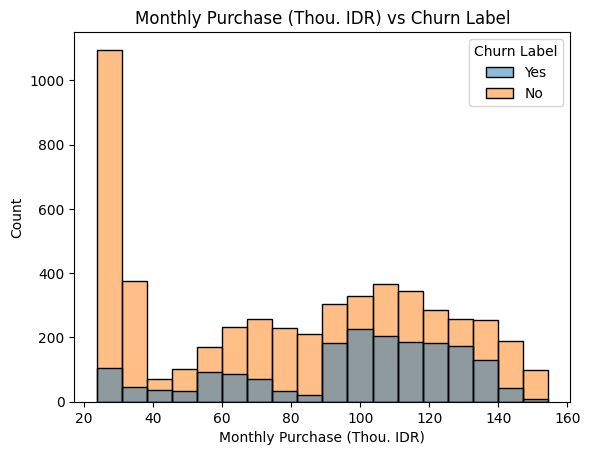

In [25]:
sns.histplot(data=df, x="Monthly Purchase (Thou. IDR)", hue="Churn Label")
plt.title("Monthly Purchase (Thou. IDR) vs Churn Label")
plt.show()

Customer also churned for low monhtly purchases, but mose of the churned users spend between Rp 100,000.00 - Rp 120,000.00 a month.

## CLTV

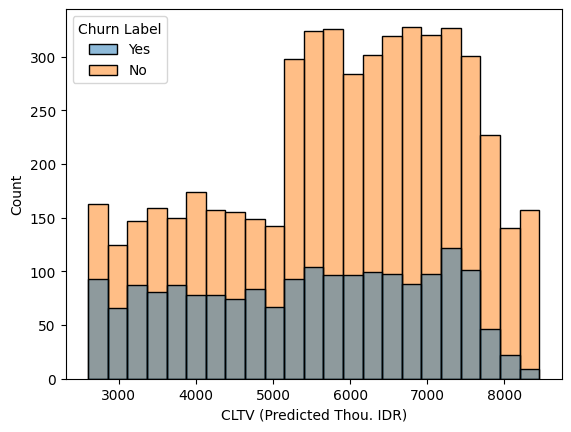

In [26]:
sns.histplot(data=df, x='CLTV (Predicted Thou. IDR)', hue='Churn Label')
plt.show()
plt.show()

CLTV can't be used as a feature because CLTV are normally distributed for all churned users, hence it is not a strong feature. The CLTV above Rp 7,500,000 has a high chance of churning.

## Call Center
Check whether the customer uses the call center service

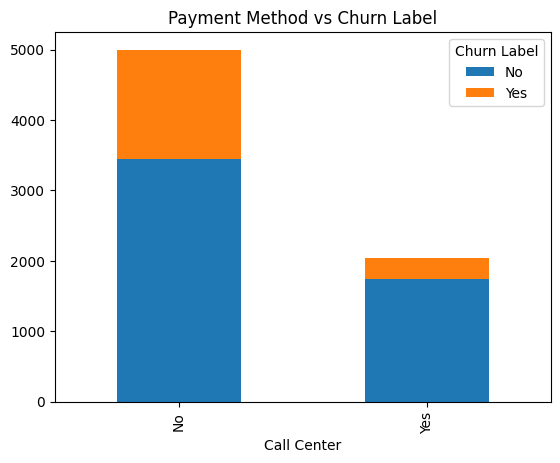

In [27]:
plot_df = df.pivot_table(index="Call Center", columns="Churn Label", values="Customer ID", aggfunc="count")
plot_df.plot(kind="bar", stacked=True)
plt.title("Payment Method vs Churn Label")
plt.show()

## Total Purchase

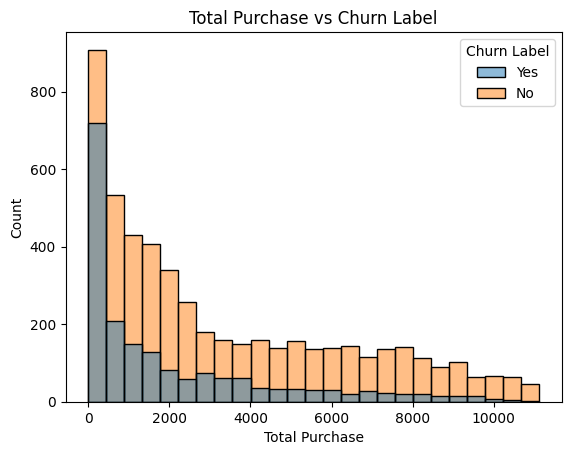

In [28]:
sns.histplot(data=df, x="Total Purchase", hue="Churn Label")
plt.title("Total Purchase vs Churn Label")
plt.show()

Really hard to tell based on the Total 

In [29]:
df

,Customer ID,Tenure Months,Location,Device Class,Games Product,Music Product,Education Product,Call Center,Video Product,Use MyApp,Payment Method,Monthly Purchase (Thou. IDR),Churn Label,Longitude,Latitude,CLTV (Predicted Thou. IDR),Internet Service,Churn,Total Purchase,Tenure Months Bin
0,0,2,Jakarta,Mid End,Yes,Yes,No,No,No,No,Digital Wallet,70.005,Yes,106.816666,-6.2,4210.7,1,1,140.01,"(-0.072, 7.2]"
1,1,2,Jakarta,High End,No,No,No,No,No,No,Pulsa,91.910,Yes,106.816666,-6.2,3511.3,1,1,183.82,"(-0.072, 7.2]"
2,2,8,Jakarta,High End,No,No,Yes,No,Yes,Yes,Pulsa,129.545,Yes,106.816666,-6.2,6983.6,1,1,1036.36,"(7.2, 14.4]"
3,3,28,Jakarta,High End,No,No,Yes,Yes,Yes,Yes,Pulsa,136.240,Yes,106.816666,-6.2,6503.9,1,1,3814.72,"(21.6, 28.8]"
4,4,49,Jakarta,High End,No,Yes,Yes,No,Yes,Yes,Debit,134.810,Yes,106.816666,-6.2,6942.0,1,1,6605.69,"(43.2, 50.4]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,7038,72,Jakarta,Low End,No internet service,No internet service,No internet service,No,No internet service,No internet service,Debit,27.495,No,106.816666,-6.2,6897.8,0,0,1979.64,"(64.8, 72.0]"
7039,7039,24,Jakarta,Mid End,Yes,No,Yes,Yes,Yes,Yes,Digital Wallet,110.240,No,106.816666,-6.2,2782.0,1,0,2645.76,"(21.6, 28.8]"
7040,7040,72,Jakarta,High End,No,Yes,Yes,No,Yes,Yes,Credit,134.160,No,106.816666,-6.2,7228.0,1,0,9659.52,"(64.8, 72.0]"
7041,7041,11,Jakarta,Mid End,Yes,No,No,No,No,No,Pulsa,38.480,No,106.816666,-6.2,3630.9,1,0,423.28,"(7.2, 14.4]"


## Used Products

<function matplotlib.pyplot.show(close=None, block=None)>

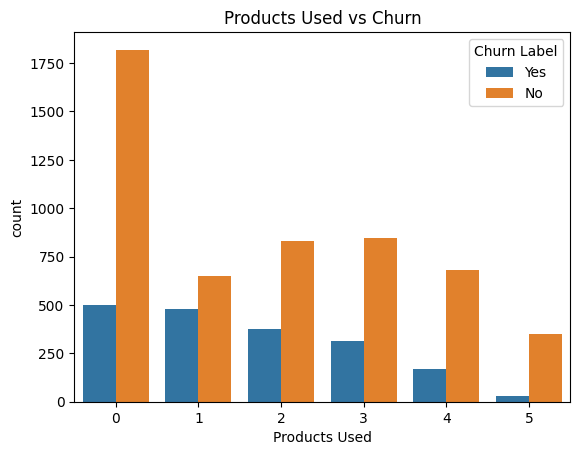

In [30]:
def uses_internet_for_product(data):
    if data == "Yes": 
        return 1
    return 0

# Total Product Used
df["Products Used"] = df[['Games Product', 'Music Product', 'Education Product', 'Video Product', 'Use MyApp']]\
    .apply(lambda x: uses_internet_for_product(x['Games Product'])
        + uses_internet_for_product(x['Music Product'])
        + uses_internet_for_product(x['Education Product'])
        + uses_internet_for_product(x['Video Product'])
        + uses_internet_for_product(x['Use MyApp']), axis=1)

sns.countplot(data=df, x="Products Used", hue="Churn Label")
plt.title("Products Used vs Churn")
plt.show
# df

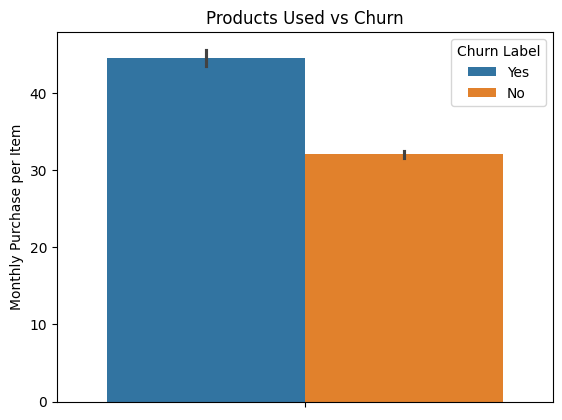

In [31]:
df["Monthly Purchase per Item"] = df["Monthly Purchase (Thou. IDR)"] / (df["Products Used"]+1)

sns.barplot(data=df, y="Monthly Purchase per Item", hue="Churn Label")
plt.title("Products Used vs Churn")
plt.show()

User that pay more and use little of the product services has a high chance of churning

## Correlation Map

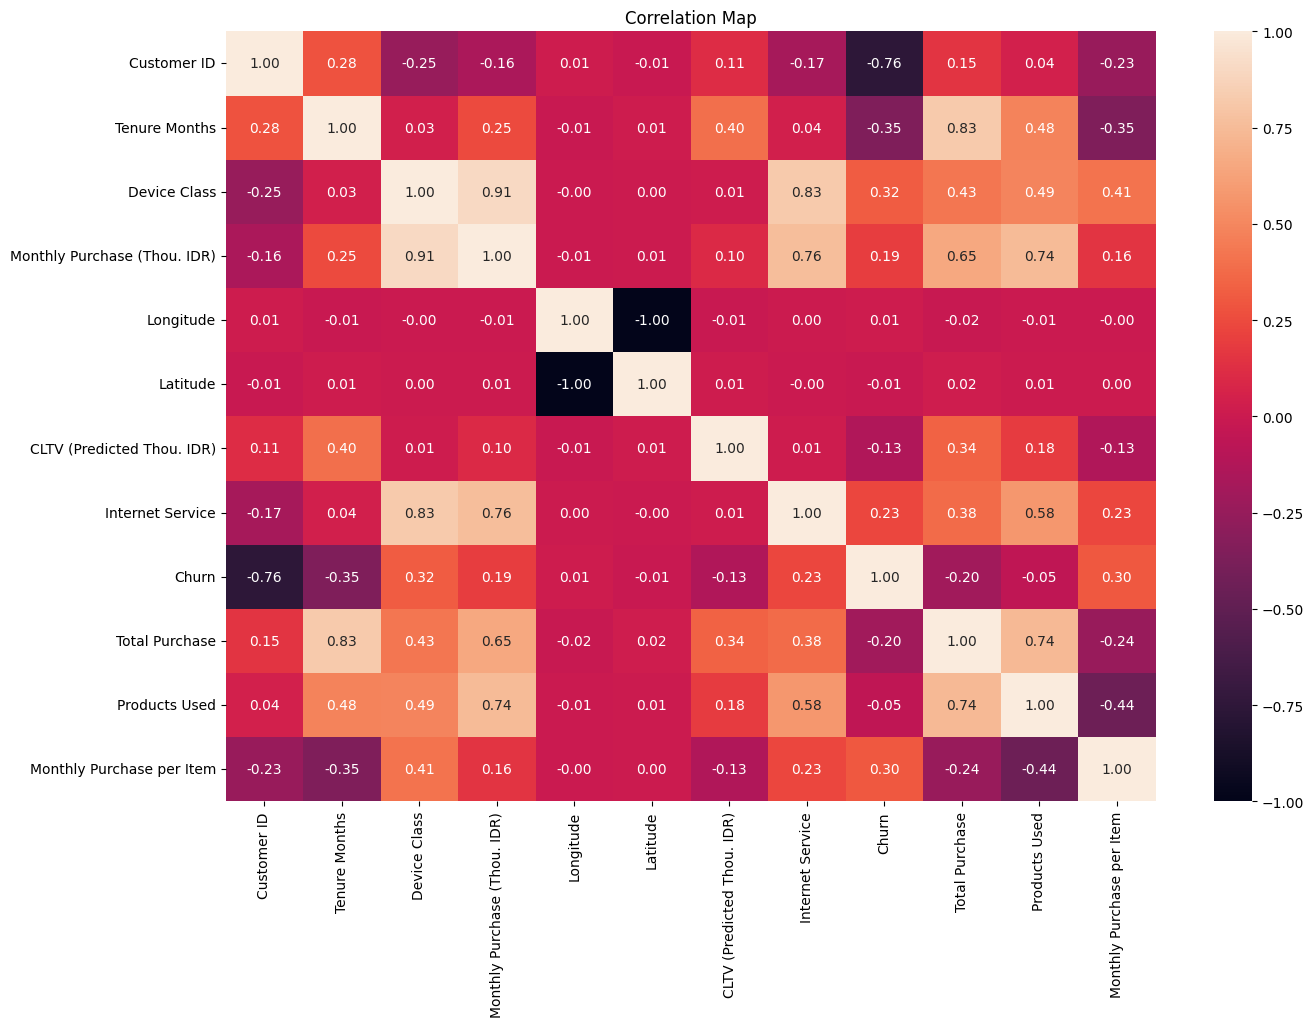

In [32]:
device_class_map = {
    "High End": 3,
    "Mid End": 2,
    "Low End": 1
}
df["Device Class"] = df["Device Class"].replace(device_class_map)
corr = df.select_dtypes([int, float]).corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corr, annot=True, fmt=".2f")
plt.title("Correlation Map")
plt.show()

# Modelling

In [48]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# imports
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score, roc_curve, accuracy_score
from imblearn.metrics import specificity_score
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit

# machine learning model
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    AdaBoostClassifier, 
    RandomForestClassifier,
    ExtraTreesClassifier,
    GradientBoostingClassifier,
    VotingClassifier
)
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (recall_score, precision_score, f1_score, roc_auc_score)
from sklearn.model_selection import (train_test_split, StratifiedShuffleSplit, cross_val_score)
from sklearn.preprocessing import StandardScaler
import catboost as cb
import xgboost as xgb
import lightgbm as lgb


# oversampling
from imblearn.over_sampling import (
    RandomOverSampler,
    SMOTE, 
    BorderlineSMOTE,
    SVMSMOTE
)

# hyperparameter tuning
import optuna

In [10]:
def evaluate(model, y_true, y_pred, y_pred_proba):
    """
        Evaluate model performance
    """
    print(f"""
    METRICS
    Accuracy: {accuracy_score(y_true, y_pred)}
    Precision: {precision_score(y_true, y_pred)}
    Recall: {recall_score(y_true, y_pred)}
    F1 Score: {f1_score(y_true, y_pred)}
    ROC AUC score: {roc_auc_score(y_true, y_pred)}
    Specificity: {specificity_score(y_true, y_pred)}
    """)

    # confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=model.classes_)
    display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    display.plot()
    plt.title(f"Confusion Matrix of {model.__class__.__name__}")
    plt.show()

    # ROC curve plot
    fpr, tpr, _ = roc_curve(y_true,  y_pred_proba[:, -1])
    plt.plot(fpr, tpr)
    plt.plot((0, 1), (0, 1))
    plt.title("ROC Curve")
    plt.show()

## Baseline Model AKA. Dummy Classifier


    METRICS
    Accuracy: 0.6195883605393896
    Precision: 0.29336734693877553
    Recall: 0.3074866310160428
    F1 Score: 0.3002610966057441
    ROC AUC score: 0.5199268903872485
    Specificity: 0.7323671497584541
    


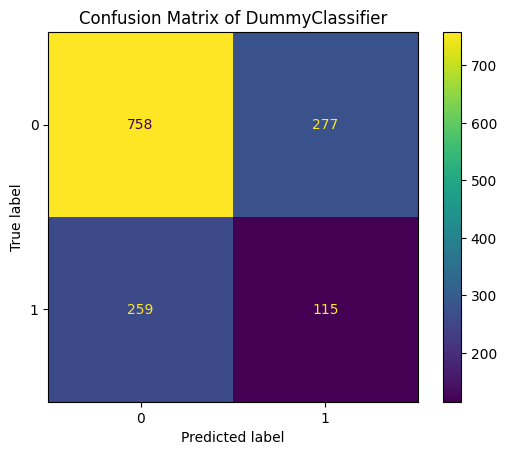

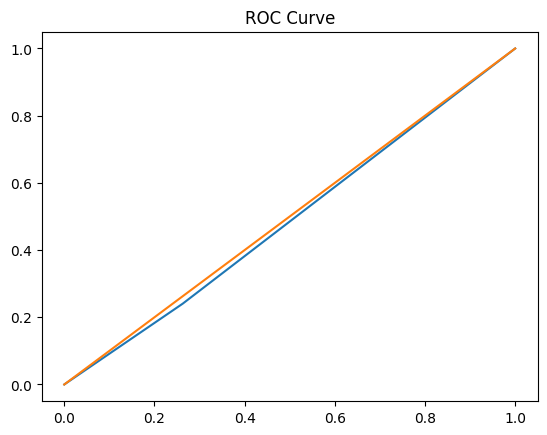

In [11]:
# Data Preparation
# ==============================================
df = df_ori.copy().drop(columns=["Customer ID", "Location", "Longitude", "Latitude", "CLTV (Predicted Thou. IDR)"])  # drop unimportant data
df["Device Class"] = df["Device Class"].replace({"High End": 3, "Mid End": 2, "Low End": 1})  # encode Device Class  
df['Churn Label'] = df['Churn Label'].replace({"Yes": 1, "No": 0})  # encode Churn Label

X, y = pd.get_dummies(df.drop(columns=["Churn Label"]), dtype=int), df["Churn Label"]  # split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)

# Train Dummy Classifier
# ==============================================
model = DummyClassifier(strategy="stratified")
model.fit(X_train, y_train)

# Predict using Dummy Classifier
# ==============================================
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

# Evaluate Model
# ==============================================
evaluate(model, y_test, y_pred, y_pred_proba)

## Model Improvement

### Using Different Model

[0.50501672 0.5451505  0.52173913 0.56521739 0.48160535] 
Score Mean: 0.5237458193979933

    METRICS
    Accuracy: 0.7913413768630234
    Precision: 0.6333333333333333
    Recall: 0.5080213903743316
    F1 Score: 0.5637982195845698
    ROC AUC score: 0.7008705985688083
    Specificity: 0.893719806763285
    


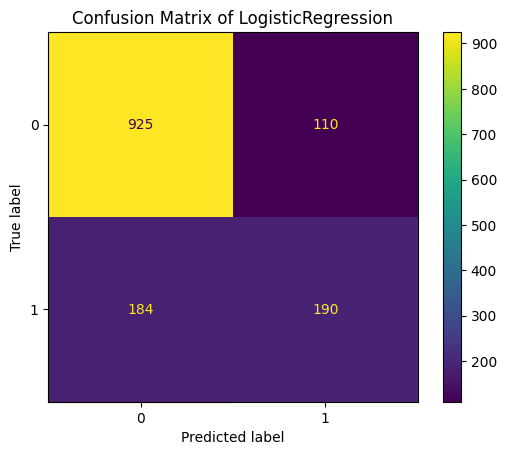

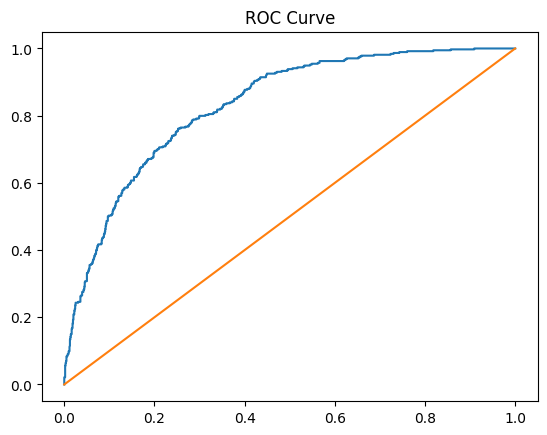

In [12]:
# Data Preparation
# ==============================================
df = df_ori.copy().drop(columns=["Customer ID", "Location", "Longitude", "Latitude", "CLTV (Predicted Thou. IDR)"])  # drop unimportant data
df["Device Class"] = df["Device Class"].replace({"High End": 3, "Mid End": 2, "Low End": 1})  # encode Device Class  
df['Churn Label'] = df['Churn Label'].replace({"Yes": 1, "No": 0})  # encode Churn Label

X, y = pd.get_dummies(df.drop(columns=["Churn Label"]), dtype=int), df["Churn Label"]  # split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)

# Cross Validation
# ========================================
model = LogisticRegression(random_state=42, max_iter=500)  # <<<<<<<<<<<<< DIFFERENT MODEL
cv = StratifiedShuffleSplit(n_splits=5,  test_size=0.2, random_state=42)
score = cross_val_score(model, X_train, y_train, cv=cv, scoring='recall')
print(score, f"\nScore Mean: {score.mean()}")


# Train Classifier
# ==============================================
model = LogisticRegression(random_state=42, max_iter=500)
model.fit(X_train, y_train)

# Predict using Classifier
# ==============================================
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

# Evaluate Model
# ==============================================
evaluate(model, y_test, y_pred, y_pred_proba)

1. We improve the specificity rate of predicting the negative class from **ground truth negative class**.
2. However we need to improve more on the recall and precision.

### Scaling Data

[0.50501672 0.5451505  0.52173913 0.56856187 0.48160535] 
Score Mean: 0.5244147157190635

    METRICS
    Accuracy: 0.7906316536550745
    Precision: 0.632996632996633
    Recall: 0.5026737967914439
    F1 Score: 0.5603576751117735
    ROC AUC score: 0.6986798935648041
    Specificity: 0.8946859903381642
    


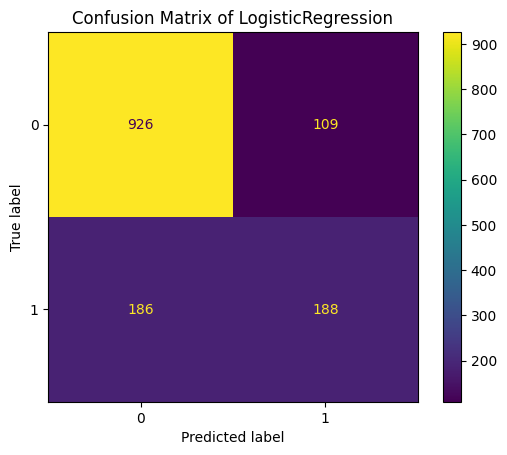

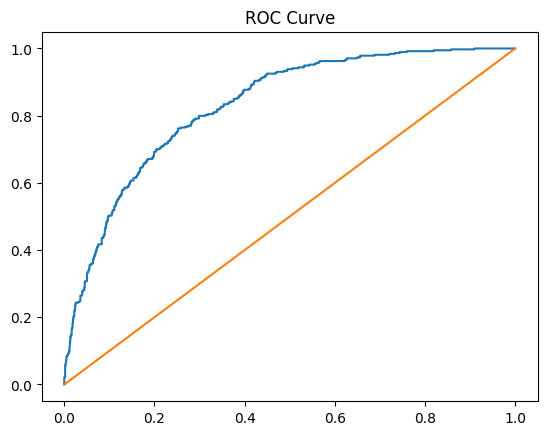

In [13]:
# Data Preparation
# ==============================================
df = df_ori.copy().drop(columns=["Customer ID", "Location", "Longitude", "Latitude", "CLTV (Predicted Thou. IDR)"])  # drop unimportant data
df["Device Class"] = df["Device Class"].replace({"High End": 3, "Mid End": 2, "Low End": 1})  # encode Device Class  
df['Churn Label'] = df['Churn Label'].replace({"Yes": 1, "No": 0})  # encode Churn Label
X, y = pd.get_dummies(df.drop(columns=["Churn Label"]), dtype=int), df["Churn Label"]  # split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)

# Scale data
# ========================================
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # <<<<<<<<<<<<< SCALING
X_test = scaler.transform(X_test)  # <<<<<<<<<<<<< SCALING

# Cross Validation
# ========================================
model = LogisticRegression(random_state=42, max_iter=500)  # <<<<<<<<<<<<< DIFFERENT MODEL
cv = StratifiedShuffleSplit(n_splits=5,  test_size=0.2, random_state=42)
score = cross_val_score(model, X_train, y_train, cv=cv, scoring='recall')
print(score, f"\nScore Mean: {score.mean()}")


# Train Classifier
# ==============================================
model = LogisticRegression(random_state=42, max_iter=500)
model.fit(X_train, y_train)

# Predict using Classifier
# ==============================================
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

# Evaluate Model
# ==============================================
evaluate(model, y_test, y_pred, y_pred_proba)

Model improve just a little

### Feature Engineering

In [14]:
# function for feature engineering
def check_internet_service(row): 
    if row['Games Product'] == "No internet service"\
        and row['Music Product'] == "No internet service"\
        and row['Education Product'] == "No internet service"\
        and row['Video Product'] == "No internet service"\
        and row['Use MyApp'] == "No internet service":
        return 0
    else: return 1

def uses_internet_for_product(data):
    if data == "Yes": return 1
    return 0

[0.5083612  0.54849498 0.52508361 0.56187291 0.48829431 0.51170569
 0.56521739 0.51505017 0.50167224 0.52508361] 
Score Mean: 0.5250836120401338

    METRICS
    Accuracy: 0.794889992902768
    Precision: 0.6402640264026402
    Recall: 0.5187165775401069
    F1 Score: 0.5731166912850812
    ROC AUC score: 0.7067012839391356
    Specificity: 0.8946859903381642
    


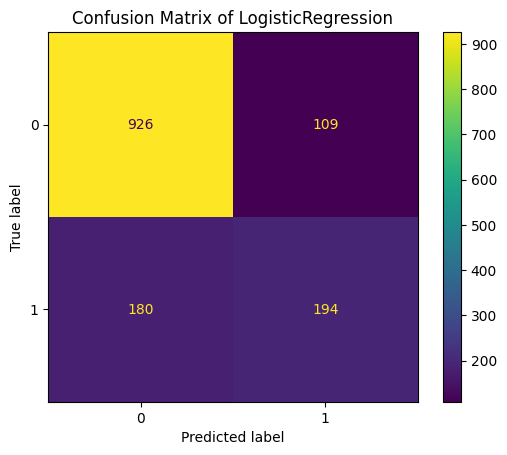

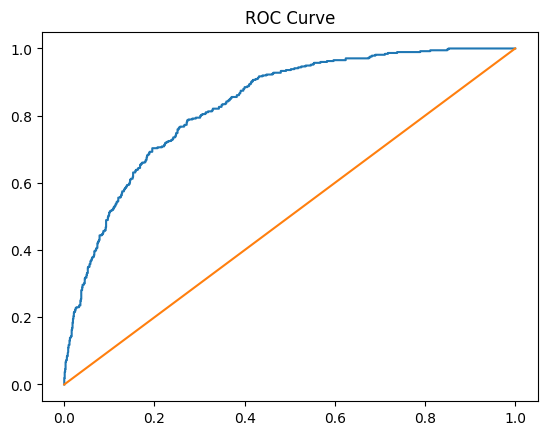

In [15]:
# Data Preparation
# ==============================================
df = df_ori.copy().drop(columns=["Customer ID", "Location", "Longitude", "Latitude", "CLTV (Predicted Thou. IDR)"])  # drop unimportant data
df['Internet Service'] = df.apply(lambda x: check_internet_service(x), axis=1)  # feature engineering
df['Total Purchase'] = df['Tenure Months'] * df['Monthly Purchase (Thou. IDR)']  # feature engineering
df['Device Class'] = df['Device Class'].replace({'High End': 3, 'Mid End': 2, 'Low End': 1})  # encode Device Class  
df['Churn Label'] = df['Churn Label'].replace({'Yes': 1, 'No': 0})  # encode Churn Label
X, y = pd.get_dummies(df.drop(columns=['Churn Label']), dtype=int), df['Churn Label']  # split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)

# Scale data
# ========================================
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # <<<<<<<<<<<<< SCALING
X_test = scaler.transform(X_test)  # <<<<<<<<<<<<< SCALING

# Cross Validation
# ========================================
model = LogisticRegression(random_state=42, max_iter=200)  # <<<<<<<<<<<<< DIFFERENT MODEL
cv = StratifiedShuffleSplit(n_splits=10,  test_size=0.2, random_state=42)
score = cross_val_score(model, X_train, y_train, cv=cv, scoring='recall')
print(score, f'\nScore Mean: {score.mean()}')

# Train Dummy Classifier
# ==============================================
model = LogisticRegression(random_state=42, max_iter=200)
model.fit(X_train, y_train)

# Predict using Dummy Classifier
# ==============================================
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

# Evaluate Model
# ==============================================
evaluate(model, y_test, y_pred, y_pred_proba)

Exist some multicllinearity between Total Purchases with CLTV, Tenure Months, Monthly Purchase and Device Classes. Let's try to perform PCA on it

### Perform Oversampling
Oversampling is used to tackle imbalance class problem

In [16]:
# Data Preparation
# ==============================================
df = df_ori.copy().drop(columns=["Customer ID", "Location", "Longitude", "Latitude", "CLTV (Predicted Thou. IDR)"])  # drop unimportant data
df["Internet Service"] = df.apply(lambda x: check_internet_service(x), axis=1)  # feature engineering
df["Total Purchase"] = df["Tenure Months"] * df["Monthly Purchase (Thou. IDR)"]  # feature engineering
df["Device Class"] = df["Device Class"].replace({"High End": 3, "Mid End": 2, "Low End": 1})  # encode Device Class  
df["Churn Label"] = df["Churn Label"].replace({"Yes": 1, "No": 0})  # encode Churn Label
X, y = pd.get_dummies(df.drop(columns=["Churn Label"]), dtype=int), df["Churn Label"]  # split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)

oversampler_method = []
recalls = []
precisions = [] 
f1_scores = []
roc_aucs = []

for oversampler in [
        RandomOverSampler(random_state = 42),
        SMOTE(random_state = 42),
        BorderlineSMOTE(random_state = 42),
        SVMSMOTE(random_state = 42),
    ]:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)
    
    # Oversampling for balancing dataset
    # ==============================================
    X_train, y_train = oversampler.fit_resample(X_train, y_train)  # <<<<<<<<<<<<< OVERSAMPLING

    # Scale data
    # ========================================
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)  # <<<<<<<<<<<<< SCALING
    X_test = scaler.transform(X_test)  # <<<<<<<<<<<<< SCALING

    # Cross Validation
    # ========================================
    model = LogisticRegression(random_state=42, max_iter=200)
    cv = StratifiedShuffleSplit(n_splits=5,  test_size=0.2, random_state=42)
    recall = cross_val_score(model, X_train, y_train, cv=cv, scoring="recall")
    precision = cross_val_score(model, X_train, y_train, cv=cv, scoring="precision")
    f1 = cross_val_score(model, X_train, y_train, cv=cv, scoring="f1")
    roc_auc = cross_val_score(model, X_train, y_train, cv=cv, scoring="roc_auc")
    
    # Document The Result
    # ========================================
    oversampler_method.append(oversampler.__class__.__name__)
    recalls.append(recall.mean())
    precisions.append(precision.mean())
    f1_scores.append(f1.mean())
    roc_aucs.append(roc_auc.mean())

result_df = pd.DataFrame({
    "Method": oversampler_method,
    "Recall": recalls,
    "Precision": precisions,
    "F1 Score": f1_scores,
    "ROC AUC": roc_aucs,
})
result_df

,Method,Recall,Precision,F1 Score,ROC AUC
0,RandomOverSampler,0.777536,0.750166,0.763497,0.837239
1,SMOTE,0.820290,0.871803,0.845216,0.928633
2,BorderlineSMOTE,0.818116,0.877035,0.846536,0.930561
3,SVMSMOTE,0.850000,0.843030,0.846466,0.922238


Best performing oversampling method based on f1 score

### Try Other Models

In [49]:
models = [
    LogisticRegression(random_state=42, max_iter=200), SVC(), KNeighborsClassifier(), GaussianNB(),
    DecisionTreeClassifier(random_state=42), RandomForestClassifier(random_state=42), 
    AdaBoostClassifier(random_state=42), GradientBoostingClassifier(random_state=42), xgb.XGBClassifier(random_state=42),
    cb.CatBoostClassifier(random_state=42), lgb.LGBMClassifier(objective='binary', random_state=42), ExtraTreesClassifier(random_state=42)
]

recalls = []
precisions = []
f1s = []
roc_aucs = []

for model in models:
    # Data Preparation
    # ==============================================
    df = df_ori.copy().drop(columns=["Customer ID", "Location", "Longitude", "Latitude", "CLTV (Predicted Thou. IDR)"])  # drop unimportant data
    df["Internet Service"] = df.apply(lambda x: check_internet_service(x), axis=1)  # feature engineering
    df['Total Purchase'] = df['Tenure Months'] * df['Monthly Purchase (Thou. IDR)']  # feature engineering
    df["Device Class"] = df["Device Class"].replace({"High End": 3, "Mid End": 2, "Low End": 1})  # encode Device Class  
    df['Churn Label'] = df['Churn Label'].replace({"Yes": 1, "No": 0})  # encode Churn Label
    X, y = pd.get_dummies(df.drop(columns=["Churn Label"]), dtype=int), df["Churn Label"]  # split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)

    # Oversampling for balancing dataset
    # ==============================================
    X_train, y_train = SMOTE(random_state=42).fit_resample(X_train, y_train)  # <<<<<<<<<<<<< SMOTE OVERSAMPLING

    # Scale data
    # ========================================
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)  # <<<<<<<<<<<<< SCALING
    X_test = scaler.transform(X_test)  # <<<<<<<<<<<<< SCALING
    
    # Cross Validation
    # ========================================
    cv = StratifiedShuffleSplit(n_splits=5,  test_size=0.2, random_state=42)
    score = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1')
    f1s.append(score.mean())
    print(f"{model.__class__.__name__} done")

    
df_model = pd.DataFrame(
    {
        "Model": [model.__class__.__name__ for model in models],
        "F1 Score": f1s,
    }
)

df_model.sort_values(by="F1 Score", ascending=False)

LogisticRegression done
SVC done
KNeighborsClassifier done
GaussianNB done
DecisionTreeClassifier done
RandomForestClassifier done
AdaBoostClassifier done
GradientBoostingClassifier done
XGBClassifier done
Learning rate set to 0.023094
0:	learn: 0.6803359	total: 5.4ms	remaining: 5.4s
1:	learn: 0.6685126	total: 10.4ms	remaining: 5.2s
2:	learn: 0.6548260	total: 15.3ms	remaining: 5.08s
3:	learn: 0.6417606	total: 20.2ms	remaining: 5.02s
4:	learn: 0.6294777	total: 24.9ms	remaining: 4.95s
5:	learn: 0.6176870	total: 29.7ms	remaining: 4.92s
6:	learn: 0.6019134	total: 34.6ms	remaining: 4.91s
7:	learn: 0.5939886	total: 39.3ms	remaining: 4.87s
8:	learn: 0.5797524	total: 44.7ms	remaining: 4.92s
9:	learn: 0.5718645	total: 49.4ms	remaining: 4.89s
10:	learn: 0.5618070	total: 54.4ms	remaining: 4.89s
11:	learn: 0.5555586	total: 59.7ms	remaining: 4.91s
12:	learn: 0.5473708	total: 64.6ms	remaining: 4.91s
13:	learn: 0.5412707	total: 69.5ms	remaining: 4.9s
14:	learn: 0.5338440	total: 74.7ms	remaining: 4.91

,Model,F1 Score
7,GradientBoostingClassifier,0.854745
9,CatBoostClassifier,0.854422
10,LGBMClassifier,0.852949
8,XGBClassifier,0.846993
6,AdaBoostClassifier,0.846708
0,LogisticRegression,0.845216
5,RandomForestClassifier,0.839245
1,SVC,0.831888
2,KNeighborsClassifier,0.828719
11,ExtraTreesClassifier,0.823424


CatBoostClassifier, GradientBoostingClassifier, LGBMClassifier, LogisticRegression, AdaBoostClassifier are the best models. Let's check on the performance on test data

In [17]:
models = [
    LogisticRegression(random_state=42, max_iter=200), RandomForestClassifier(random_state=42),
    GradientBoostingClassifier(random_state=42), AdaBoostClassifier(random_state=42), xgb.XGBClassifier(random_state=42),
    cb.CatBoostClassifier(random_state=42), lgb.LGBMClassifier(objective='binary', random_state=42)
]

recalls = []
precisions = []
f1s = []
roc_aucs = []
threshold=0.5

for model in models:
    # Data Preparation
    # ==============================================
    df = df_ori.copy().drop(columns=["Customer ID", "Location", "Longitude", "Latitude", "CLTV (Predicted Thou. IDR)"])  # drop unimportant data
    df["Internet Service"] = df.apply(lambda x: check_internet_service(x), axis=1)  # feature engineering
    df['Total Purchase'] = df['Tenure Months'] * df['Monthly Purchase (Thou. IDR)']  # feature engineering
    df["Device Class"] = df["Device Class"].replace({"High End": 3, "Mid End": 2, "Low End": 1})  # encode Device Class  
    df['Churn Label'] = df['Churn Label'].replace({"Yes": 1, "No": 0})  # encode Churn Label
    X, y = pd.get_dummies(df.drop(columns=["Churn Label"]), dtype=int), df["Churn Label"]  # split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)

    # Oversampling for balancing dataset
    # ==============================================
    smote = SMOTE(random_state=42)  # <<<<<<<<<<<<< SMOTE OVERSAMPLING
    X_train, y_train = smote.fit_resample(X_train, y_train)  # <<<<<<<<<<<<< SMOTE OVERSAMPLING

    # Scale data
    # ========================================
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)  # <<<<<<<<<<<<< SCALING
    X_test = scaler.transform(X_test)  # <<<<<<<<<<<<< SCALING
    
    # Train
    # ==============================================
    model.fit(X_train, y_train)

    # Predict
    # ==============================================
    y_pred_proba = model.predict_proba(X_test)
    y_pred = [1 if prob > threshold else 0 for prob in y_pred_proba[:, 1]]
    recalls.append(recall_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred))
    f1s.append(f1_score(y_test, y_pred))
    roc_aucs.append(roc_auc_score(y_test, y_pred))
    
df_model = pd.DataFrame(
    {
        "Model Name": [model.__class__.__name__ for model in models],
        "Threshold": [threshold for _ in range(len(models))],
        "Recall": recalls,
        "Precisions": precisions,
        "F1 Score": f1s,
        "ROC AUC Score": roc_aucs,
    }
)

df_model.sort_values(by="F1 Score", ascending=False)

Learning rate set to 0.025403
0:	learn: 0.6794210	total: 148ms	remaining: 2m 27s
1:	learn: 0.6667055	total: 153ms	remaining: 1m 16s
2:	learn: 0.6508131	total: 157ms	remaining: 52.2s
3:	learn: 0.6359426	total: 161ms	remaining: 40.2s
4:	learn: 0.6221143	total: 166ms	remaining: 33s
5:	learn: 0.6093900	total: 170ms	remaining: 28.2s
6:	learn: 0.6003711	total: 174ms	remaining: 24.7s
7:	learn: 0.5889429	total: 179ms	remaining: 22.2s
8:	learn: 0.5803005	total: 184ms	remaining: 20.2s
9:	learn: 0.5701675	total: 188ms	remaining: 18.6s
10:	learn: 0.5594717	total: 192ms	remaining: 17.3s
11:	learn: 0.5453879	total: 197ms	remaining: 16.2s
12:	learn: 0.5354684	total: 203ms	remaining: 15.4s
13:	learn: 0.5277140	total: 208ms	remaining: 14.7s
14:	learn: 0.5200432	total: 214ms	remaining: 14s
15:	learn: 0.5130408	total: 220ms	remaining: 13.5s
16:	learn: 0.5072319	total: 225ms	remaining: 13s
17:	learn: 0.5019070	total: 231ms	remaining: 12.6s
18:	learn: 0.4973744	total: 236ms	remaining: 12.2s
19:	learn: 0.48

,Model Name,Threshold,Recall,Precisions,F1 Score,ROC AUC Score
3,AdaBoostClassifier,0.5,0.665775,0.554566,0.605103,0.736269
2,GradientBoostingClassifier,0.5,0.628342,0.581683,0.604113,0.732529
0,LogisticRegression,0.5,0.588235,0.619718,0.603567,0.728900
5,CatBoostClassifier,0.5,0.561497,0.589888,0.575342,0.710217
6,LGBMClassifier,0.5,0.553476,0.596542,0.574202,0.709105
4,XGBClassifier,0.5,0.534759,0.586510,0.559441,0.699264
1,RandomForestClassifier,0.5,0.521390,0.573529,0.546218,0.690647


# Hyperparameter Tuning

## Logistic Regression

In [18]:
# Data Preparation
# ==============================================
df = df_ori.copy().drop(columns=["Customer ID", "Location", "Longitude", "Latitude", "CLTV (Predicted Thou. IDR)"])  # drop unimportant data
df["Internet Service"] = df.apply(lambda x: check_internet_service(x), axis=1)  # feature engineering
df['Total Purchase'] = df['Tenure Months'] * df['Monthly Purchase (Thou. IDR)']  # feature engineering
df["Device Class"] = df["Device Class"].replace({"High End": 3, "Mid End": 2, "Low End": 1})  # encode Device Class  
df['Churn Label'] = df['Churn Label'].replace({"Yes": 1, "No": 0})  # encode Churn Label
X, y = pd.get_dummies(df.drop(columns=["Churn Label"]), dtype=int), df["Churn Label"]  # split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y, shuffle=True)

# Oversampling for balancing dataset
# ==============================================
smote = SMOTE(random_state=42)  # <<<<<<<<<<<<< SMOTE OVERSAMPLING
X_train, y_train = smote.fit_resample(X_train, y_train)  # <<<<<<<<<<<<< SMOTE OVERSAMPLING

# Scale data
# ==============================================
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # <<<<<<<<<<<<< SCALING
X_val = scaler.transform(X_val)  # <<<<<<<<<<<<< SCALING
X_test = scaler.transform(X_test)  # <<<<<<<<<<<<< SCALING

# Hyperparameter Tuning
# ==============================================
def objective(trial):
    # Hyperparameters
    # ==============================================
    param = {
        "C": trial.suggest_float("C", 0.0001, 4, log=True),
        "solver": trial.suggest_categorical("solver", ["lbfgs", "liblinear", "newton-cg", "newton-cholesky"]),
        "max_iter": 200
    }

    # Cross validation
    # ==============================================
    model = LogisticRegression(**param, random_state=42)
    cv = StratifiedShuffleSplit(n_splits=5,  test_size=0.2, random_state=42)
    score = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1')
    return score.mean()

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))


# Train using best parameters
# ==============================================
model = LogisticRegression(**study.best_params, random_state=42)
model.fit(X_train, y_train)

# Predict
# ==============================================
preds = model.predict(X_test)
y_pred = np.rint(preds)
print(f"""
Recalls: {recall_score(y_test, y_pred):.3f}
Precision: {precision_score(y_test, y_pred):.3f}
F1 Score: {f1_score(y_test, y_pred):.3f}
ROC AUC SCORE: {roc_auc_score(y_test, y_pred):.3f}
""")

[I 2023-11-05 14:43:49,422] A new study created in memory with name: no-name-599573f5-77ba-4da6-a76a-af1d413ade91
[I 2023-11-05 14:43:49,645] Trial 0 finished with value: 0.8291766214208665 and parameters: {'C': 0.004450059772128648, 'solver': 'newton-cg'}. Best is trial 0 with value: 0.8291766214208665.
[I 2023-11-05 14:43:49,745] Trial 1 finished with value: 0.8439288557363749 and parameters: {'C': 0.0834796098295634, 'solver': 'newton-cholesky'}. Best is trial 1 with value: 0.8439288557363749.
[I 2023-11-05 14:43:50,098] Trial 2 finished with value: 0.8486157056886963 and parameters: {'C': 0.7885269415701741, 'solver': 'newton-cg'}. Best is trial 2 with value: 0.8486157056886963.
[I 2023-11-05 14:43:50,242] Trial 3 finished with value: 0.8388888300513335 and parameters: {'C': 0.01550291055952815, 'solver': 'lbfgs'}. Best is trial 2 with value: 0.8486157056886963.
[I 2023-11-05 14:43:50,305] Trial 4 finished with value: 0.792735141926657 and parameters: {'C': 0.0001317783285705546, '

Number of finished trials:  50
Best trial:
  Value: 0.8493652532460942
  Params: 
    C: 3.3850736097781917
    solver: newton-cholesky

Recalls: 0.596
Precision: 0.619
F1 Score: 0.608
ROC AUC SCORE: 0.732



## Random Forest

In [76]:
# Data Preparation
# ==============================================
df = df_ori.copy().drop(columns=["Customer ID", "Location", "Longitude", "Latitude", "CLTV (Predicted Thou. IDR)"])  # drop unimportant data
df["Internet Service"] = df.apply(lambda x: check_internet_service(x), axis=1)  # feature engineering
df['Total Purchase'] = df['Tenure Months'] * df['Monthly Purchase (Thou. IDR)']  # feature engineering
df["Device Class"] = df["Device Class"].replace({"High End": 3, "Mid End": 2, "Low End": 1})  # encode Device Class  
df['Churn Label'] = df['Churn Label'].replace({"Yes": 1, "No": 0})  # encode Churn Label
X, y = pd.get_dummies(df.drop(columns=["Churn Label"]), dtype=int), df["Churn Label"]  # split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y, shuffle=True)

# Oversampling for balancing dataset
# ==============================================
smote = SMOTE(random_state=42)  # <<<<<<<<<<<<< SMOTE OVERSAMPLING
X_train, y_train = smote.fit_resample(X_train, y_train)  # <<<<<<<<<<<<< SMOTE OVERSAMPLING

# Scale data
# ==============================================
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # <<<<<<<<<<<<< SCALING
X_val = scaler.transform(X_val)  # <<<<<<<<<<<<< SCALING
X_test = scaler.transform(X_test)  # <<<<<<<<<<<<< SCALING

# Hyperparameter Tuning
# ==============================================
def objective(trial):
    # Hyperparameters
    # ==============================================
    param = {
        "max_depth": trial.suggest_int("max_depth", 3, 10, 1),
        "min_samples_split": trial.suggest_int("min_samples_split", 50, 200),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 50, 200),
        "n_estimators": trial.suggest_int("n_estimators", 200, 1000, 100),
        "max_samples": trial.suggest_float("max_samples", 0.5, 0.9, step=0.1),
        "max_features": trial.suggest_int("max_features", 1, len(X.columns)),
        "bootstrap": True
    }

    # Cross validation
    # ==============================================
    model = RandomForestClassifier(**param, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    return f1_score(y_val, y_pred)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=25)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))


# Train using best parameters
# ==============================================
model = RandomForestClassifier(**study.best_params, random_state=42)
model.fit(X_train, y_train)

# Predict
# ==============================================
preds = model.predict(X_test)
y_pred = np.rint(preds)
print(f"""
Recalls: {recall_score(y_test, y_pred):.3f}
Precision: {precision_score(y_test, y_pred):.3f}
F1 Score: {f1_score(y_test, y_pred):.3f}
ROC AUC SCORE: {roc_auc_score(y_test, y_pred):.3f}
""")

[I 2023-11-05 10:22:23,755] A new study created in memory with name: no-name-425815b6-fabd-4177-972a-a724c6be7052
[I 2023-11-05 10:22:25,671] Trial 0 finished with value: 0.6185266229029904 and parameters: {'max_depth': 4, 'min_samples_split': 138, 'min_samples_leaf': 90, 'n_estimators': 300, 'max_samples': 0.8, 'max_features': 6}. Best is trial 0 with value: 0.6185266229029904.
[I 2023-11-05 10:22:31,432] Trial 1 finished with value: 0.6102449888641427 and parameters: {'max_depth': 7, 'min_samples_split': 159, 'min_samples_leaf': 125, 'n_estimators': 400, 'max_samples': 0.5, 'max_features': 25}. Best is trial 0 with value: 0.6185266229029904.
[I 2023-11-05 10:22:35,231] Trial 2 finished with value: 0.607242339832869 and parameters: {'max_depth': 3, 'min_samples_split': 74, 'min_samples_leaf': 129, 'n_estimators': 300, 'max_samples': 0.8, 'max_features': 23}. Best is trial 0 with value: 0.6185266229029904.
[I 2023-11-05 10:23:13,190] Trial 3 finished with value: 0.594059405940594 and p

Number of finished trials:  25
Best trial:
  Value: 0.6288274831964152
  Params: 
    max_depth: 9
    min_samples_split: 200
    min_samples_leaf: 200
    n_estimators: 900
    max_samples: 0.5
    max_features: 13

Recalls: 0.751
Precision: 0.535
F1 Score: 0.625
ROC AUC SCORE: 0.758



## CatBoostClassifier

In [57]:
from catboost import Pool, cv
# Data Preparation
# ==============================================
df = df_ori.copy().drop(columns=["Customer ID", "Location", "Longitude", "Latitude", "CLTV (Predicted Thou. IDR)"])  # drop unimportant data
df["Internet Service"] = df.apply(lambda x: check_internet_service(x), axis=1)  # feature engineering
df['Total Purchase'] = df['Tenure Months'] * df['Monthly Purchase (Thou. IDR)']  # feature engineering
df["Device Class"] = df["Device Class"].replace({"High End": 3, "Mid End": 2, "Low End": 1})  # encode Device Class  
df['Churn Label'] = df['Churn Label'].replace({"Yes": 1, "No": 0})  # encode Churn Label
X, y = pd.get_dummies(df.drop(columns=["Churn Label"]), dtype=int), df["Churn Label"]  # split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y, shuffle=True)

# Oversampling for balancing dataset
# ==============================================
smote = SMOTE(random_state=42)  # <<<<<<<<<<<<< SMOTE OVERSAMPLING
X_train, y_train = smote.fit_resample(X_train, y_train)  # <<<<<<<<<<<<< SMOTE OVERSAMPLING

# Scale data
# ==============================================
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # <<<<<<<<<<<<< SCALING
X_val = scaler.transform(X_val)  # <<<<<<<<<<<<< SCALING
X_test = scaler.transform(X_test)  # <<<<<<<<<<<<< SCALING

# Hyperparameter Tuning
# ==============================================
def objective(trial):
    # Hyperparameters
    # ==============================================
    param = {
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "used_ram_limit": "3gb",
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    # Cross validation
    # ==============================================
    model = cb.CatBoostClassifier(**param)
    model.fit(X_train, y_train, verbose=0)
    preds = model.predict(X_val)
    y_pred = np.rint(preds)
    return f1_score(y_val, y_pred)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=25)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))


# Train using best parameters
# ==============================================
model = cb.CatBoostClassifier(**study.best_params)
model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=0, early_stopping_rounds=100)


# Predict
# ==============================================
preds = model.predict(X_test)
y_pred = np.rint(preds)
print(f"""
Recalls: {recall_score(y_test, y_pred):.3f}
Precision: {precision_score(y_test, y_pred):.3f}
F1 Score: {f1_score(y_test, y_pred):.3f}
ROC AUC SCORE: {roc_auc_score(y_test, y_pred):.3f}
""")

[I 2023-11-05 09:34:52,955] A new study created in memory with name: no-name-d6cb1614-66c7-429a-b8c9-9e111843f7f9
[I 2023-11-05 09:35:27,673] Trial 0 finished with value: 0.5762394761459309 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.09517477989821671, 'depth': 12, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.39570812484528695}. Best is trial 0 with value: 0.5762394761459309.
[I 2023-11-05 09:35:35,801] Trial 1 finished with value: 0.578268876611418 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.0846577975016928, 'depth': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6300661208080218}. Best is trial 1 with value: 0.578268876611418.
[I 2023-11-05 09:35:49,135] Trial 2 finished with value: 0.5853658536585366 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.05220055704514591, 'depth': 10, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7155

Number of finished trials:  25
Best trial:
  Value: 0.6109785202863962
  Params: 
    objective: Logloss
    colsample_bylevel: 0.02590386849886261
    depth: 11
    boosting_type: Plain
    bootstrap_type: Bayesian
    bagging_temperature: 9.911079288875817

Recalls: 0.631
Precision: 0.581
F1 Score: 0.605
ROC AUC SCORE: 0.733



## XGBClassifier

In [19]:
# Data Preparation
# ==============================================
df = df_ori.copy().drop(columns=["Customer ID", "Location", "Longitude", "Latitude", "CLTV (Predicted Thou. IDR)"])  # drop unimportant data
df["Internet Service"] = df.apply(lambda x: check_internet_service(x), axis=1)  # feature engineering
df['Total Purchase'] = df['Tenure Months'] * df['Monthly Purchase (Thou. IDR)']  # feature engineering
df["Device Class"] = df["Device Class"].replace({"High End": 3, "Mid End": 2, "Low End": 1})  # encode Device Class  
df['Churn Label'] = df['Churn Label'].replace({"Yes": 1, "No": 0})  # encode Churn Label
X, y = pd.get_dummies(df.drop(columns=["Churn Label"]), dtype=int), df["Churn Label"]  # split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y, shuffle=True)

# Oversampling for balancing dataset
# ==============================================
smote = SMOTE(random_state=42)  # <<<<<<<<<<<<< SMOTE OVERSAMPLING
X_train, y_train = smote.fit_resample(X_train, y_train)  # <<<<<<<<<<<<< SMOTE OVERSAMPLING

# Scale data
# ==============================================
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # <<<<<<<<<<<<< SCALING
X_val = scaler.transform(X_val)  # <<<<<<<<<<<<< SCALING
X_test = scaler.transform(X_test)  # <<<<<<<<<<<<< SCALING

# Transform data into DMatrix
# ==============================================
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)
# Hyperparameter Tuning
# ==============================================
def objective(trial):

    # Hyperparameters
    # ==============================================
    param = {
        "verbosity": 0,
        "objective": "binary:logistic",
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
    }

    if param["booster"] in ["gbtree", "dart"]:
        param["max_depth"] = trial.suggest_int("max_depth", 3, 10, step=1)
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    bst = xgb.train(param, dtrain)
    preds = bst.predict(dvalid)
    pred_labels = np.rint(preds)
    return f1_score(y_val, pred_labels)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

# Train using best parameters
# ==============================================
model = xgb.train(study.best_params, dtrain)

# Predict
# ==============================================
preds = model.predict(dtest)
y_pred = np.rint(preds)
print(f"""
Recalls: {recall_score(y_test, y_pred):.3f}
Precision: {precision_score(y_test, y_pred):.3f}
F1 Score: {f1_score(y_test, y_pred):.3f}
ROC AUC SCORE: {roc_auc_score(y_test, y_pred):.3f}
""")

[I 2023-11-05 14:45:03,582] A new study created in memory with name: no-name-798440b1-b3cc-48cd-84d3-5eb2c4640812
[I 2023-11-05 14:45:03,610] Trial 0 finished with value: 0.6096916299559471 and parameters: {'booster': 'gblinear', 'lambda': 0.00042830117727155374, 'alpha': 0.00018101536988257823, 'subsample': 0.38424175435769237, 'colsample_bytree': 0.7135251359401986}. Best is trial 0 with value: 0.6096916299559471.
[I 2023-11-05 14:45:03,680] Trial 1 finished with value: 0.6189069423929099 and parameters: {'booster': 'gbtree', 'lambda': 1.0799644853647778e-05, 'alpha': 1.9185596546748173e-06, 'subsample': 0.8412426985829293, 'colsample_bytree': 0.49895276824493257, 'max_depth': 3, 'min_child_weight': 2, 'eta': 2.779720410081121e-06, 'gamma': 1.326332107468938e-06, 'grow_policy': 'lossguide'}. Best is trial 1 with value: 0.6189069423929099.
[I 2023-11-05 14:45:03,721] Trial 2 finished with value: 0.6063055780113177 and parameters: {'booster': 'dart', 'lambda': 0.2512065389945708, 'alph

Number of finished trials:  100
Best trial:
  Value: 0.6309148264984228
  Params: 
    booster: gbtree
    lambda: 9.512181414997377e-06
    alpha: 6.725796559624205e-07
    subsample: 0.7851877267962145
    colsample_bytree: 0.3511400455357884
    max_depth: 7
    min_child_weight: 5
    eta: 8.276692831028129e-05
    gamma: 4.674781697510346e-07
    grow_policy: lossguide

Recalls: 0.682
Precision: 0.556
F1 Score: 0.612
ROC AUC SCORE: 0.742



## LGBMClassifier

In [26]:
# Data Preparation
# ==============================================
df = df_ori.copy().drop(columns=["Customer ID", "Location", "Longitude", "Latitude", "CLTV (Predicted Thou. IDR)"])  # drop unimportant data
df["Internet Service"] = df.apply(lambda x: check_internet_service(x), axis=1)  # feature engineering
df['Total Purchase'] = df['Tenure Months'] * df['Monthly Purchase (Thou. IDR)']  # feature engineering
df["Device Class"] = df["Device Class"].replace({"High End": 3, "Mid End": 2, "Low End": 1})  # encode Device Class  
df['Churn Label'] = df['Churn Label'].replace({"Yes": 1, "No": 0})  # encode Churn Label
X, y = pd.get_dummies(df.drop(columns=["Churn Label"]), dtype=int), df["Churn Label"]  # split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y, shuffle=True)

# Oversampling for balancing dataset
# ==============================================
smote = SMOTE(random_state=42)  # <<<<<<<<<<<<< SMOTE OVERSAMPLING
X_train, y_train = smote.fit_resample(X_train, y_train)  # <<<<<<<<<<<<< SMOTE OVERSAMPLING

# Scale data
# ==============================================
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # <<<<<<<<<<<<< SCALING
X_val = scaler.transform(X_val)  # <<<<<<<<<<<<< SCALING
X_test = scaler.transform(X_test)  # <<<<<<<<<<<<< SCALING

# Hyperparameter Tuning
# ==============================================
def objective(trial):
    # Hyperparameters
    # ==============================================
    dtrain = lgb.Dataset(X_train, label=y_train)

    param = {
        "objective": "binary",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 50, 200, 50),
    }

    gbm = lgb.train(param, dtrain)
    preds = gbm.predict(X_val)
    y_pred = np.rint(preds)
    return f1_score(y_val, y_pred)


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

# Train using best parameters
# ==============================================
model = lgb.LGBMClassifier(**study.best_params, verbose=0, random_state=42)    
model.fit(X_train, y_train)

# Predict
# ==============================================
y_pred_proba = model.predict_proba(X_test)
y_pred = [1 if prob > threshold else 0 for prob in y_pred_proba[:, 1]]
print(f"""
Recalls: {recall_score(y_test, y_pred):.3f}
Precision: {precision_score(y_test, y_pred):.3f}
F1 Score: {f1_score(y_test, y_pred):.3f}
ROC AUC SCORE: {roc_auc_score(y_test, y_pred):.3f}
""")    


[I 2023-11-05 14:54:01,886] A new study created in memory with name: no-name-682bd874-baa8-4ae9-9a67-eb8135059c63
[I 2023-11-05 14:54:02,061] Trial 0 finished with value: 0.565619223659889 and parameters: {'lambda_l1': 0.0009823711085626674, 'lambda_l2': 6.992197424715442e-06, 'num_leaves': 239, 'feature_fraction': 0.7315846430441186, 'bagging_fraction': 0.7655919466123604, 'bagging_freq': 4, 'min_child_samples': 200}. Best is trial 0 with value: 0.565619223659889.
[I 2023-11-05 14:54:02,254] Trial 1 finished with value: 0.5618181818181819 and parameters: {'lambda_l1': 5.204799300201273e-06, 'lambda_l2': 0.29982340966884685, 'num_leaves': 173, 'feature_fraction': 0.5724873354878185, 'bagging_fraction': 0.707273787611453, 'bagging_freq': 6, 'min_child_samples': 200}. Best is trial 0 with value: 0.565619223659889.
[I 2023-11-05 14:54:02,377] Trial 2 finished with value: 0.5873015873015873 and parameters: {'lambda_l1': 5.209907029929132, 'lambda_l2': 4.340623116467853, 'num_leaves': 26, '

Number of finished trials:  50
Best trial:
  Value: 0.6273241713823767
  Params: 
    lambda_l1: 3.294029661328798
    lambda_l2: 0.7652261853285929
    num_leaves: 3
    feature_fraction: 0.9335787001541032
    bagging_fraction: 0.458298859099658
    bagging_freq: 2
    min_child_samples: 50
[LightGBM] [Warning] feature_fraction is set=0.9335787001541032, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9335787001541032
[LightGBM] [Warning] lambda_l1 is set=3.294029661328798, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.294029661328798
[LightGBM] [Warning] lambda_l2 is set=0.7652261853285929, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7652261853285929
[LightGBM] [Warning] bagging_fraction is set=0.458298859099658, subsample=1.0 will be ignored. Current value: bagging_fraction=0.458298859099658
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fract

## AdaBoostClassifier

In [62]:
# Data Preparation
# ==============================================
df = df_ori.copy().drop(columns=["Customer ID", "Location", "Longitude", "Latitude", "CLTV (Predicted Thou. IDR)"])  # drop unimportant data
df["Internet Service"] = df.apply(lambda x: check_internet_service(x), axis=1)  # feature engineering
df['Total Purchase'] = df['Tenure Months'] * df['Monthly Purchase (Thou. IDR)']  # feature engineering
df["Device Class"] = df["Device Class"].replace({"High End": 3, "Mid End": 2, "Low End": 1})  # encode Device Class  
df['Churn Label'] = df['Churn Label'].replace({"Yes": 1, "No": 0})  # encode Churn Label
X, y = pd.get_dummies(df.drop(columns=["Churn Label"]), dtype=int), df["Churn Label"]  # split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)

# Oversampling for balancing dataset
# ==============================================
smote = SMOTE(random_state=42)  # <<<<<<<<<<<<< SMOTE OVERSAMPLING
X_train, y_train = smote.fit_resample(X_train, y_train)  # <<<<<<<<<<<<< SMOTE OVERSAMPLING

# Scale data
# ==============================================
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # <<<<<<<<<<<<< SCALING
X_test = scaler.transform(X_test)  # <<<<<<<<<<<<< SCALING

# Hyperparameter Tuning
# ==============================================
def objective(trial):
    # Hyperparameters
    # ==============================================
    param = {
        "n_estimators":trial.suggest_int("n_estimators", 50, 500, 50),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 1.0, log=True),
        "algorithm": "SAMME.R", 
    }
    

    # Cross validation
    # ==============================================
    model = AdaBoostClassifier(**param, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    return f1_score(y_val, y_pred)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=25)
print(study.best_value)
print(study.best_params)

# Train using best parameters
# ==============================================
model = AdaBoostClassifier(**study.best_params, random_state=42)    
model.fit(X_train, y_train)

# Predict
# ==============================================
y_pred_proba = model.predict_proba(X_test)
y_pred = [1 if prob > threshold else 0 for prob in y_pred_proba[:, 1]]
print(f"""
Recalls: {recall_score(y_test, y_pred):.3f}
Precision: {precision_score(y_test, y_pred):.3f}
F1 Score: {f1_score(y_test, y_pred):.3f}
ROC AUC SCORE: {roc_auc_score(y_test, y_pred):.3f}
""")

[I 2023-11-05 09:49:52,982] A new study created in memory with name: no-name-329a1415-e6e1-4860-8e0d-fab582753c67
[I 2023-11-05 09:49:53,607] Trial 0 finished with value: 0.6179604261796043 and parameters: {'n_estimators': 50, 'learning_rate': 0.2066163088341047}. Best is trial 0 with value: 0.6179604261796043.
[I 2023-11-05 09:49:54,954] Trial 1 finished with value: 0.6134585289514867 and parameters: {'n_estimators': 100, 'learning_rate': 0.17321358226138575}. Best is trial 0 with value: 0.6179604261796043.
[I 2023-11-05 09:49:58,627] Trial 2 finished with value: 0.609991235758107 and parameters: {'n_estimators': 250, 'learning_rate': 0.4850763791868551}. Best is trial 0 with value: 0.6179604261796043.
[I 2023-11-05 09:49:59,426] Trial 3 finished with value: 0.6194690265486725 and parameters: {'n_estimators': 50, 'learning_rate': 0.4858935028645606}. Best is trial 3 with value: 0.6194690265486725.
[I 2023-11-05 09:50:01,378] Trial 4 finished with value: 0.6172208013640239 and paramete

0.6231003039513677
{'n_estimators': 350, 'learning_rate': 0.00941768578669405}

Recalls: 0.722
Precision: 0.531
F1 Score: 0.612
ROC AUC SCORE: 0.746



## Gradient Boosting

In [68]:
# Data Preparation
# ==============================================
df = df_ori.copy().drop(columns=["Customer ID", "Location", "Longitude", "Latitude", "CLTV (Predicted Thou. IDR)"])  # drop unimportant data
df["Internet Service"] = df.apply(lambda x: check_internet_service(x), axis=1)  # feature engineering
df['Total Purchase'] = df['Tenure Months'] * df['Monthly Purchase (Thou. IDR)']  # feature engineering
df["Device Class"] = df["Device Class"].replace({"High End": 3, "Mid End": 2, "Low End": 1})  # encode Device Class  
df['Churn Label'] = df['Churn Label'].replace({"Yes": 1, "No": 0})  # encode Churn Label
X, y = pd.get_dummies(df.drop(columns=["Churn Label"]), dtype=int), df["Churn Label"]  # split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)

# Oversampling for balancing dataset
# ==============================================
smote = SMOTE(random_state=42)  # <<<<<<<<<<<<< SMOTE OVERSAMPLING
X_train, y_train = smote.fit_resample(X_train, y_train)  # <<<<<<<<<<<<< SMOTE OVERSAMPLING

# Scale data
# ==============================================
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # <<<<<<<<<<<<< SCALING
X_test = scaler.transform(X_test)  # <<<<<<<<<<<<< SCALING

# Hyperparameter Tuning
# ==============================================
def objective(trial):
    # Hyperparameters
    # ==============================================
    param = {
        "max_depth": trial.suggest_int("max_depth", 3, 20),
        "min_samples_split": trial.suggest_int("min_samples_split", 50, 200, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 50, 150, 10),
        "n_estimators": trial.suggest_int("n_estimators", 200, 500, 50),
        "max_leaf_nodes": trial.suggest_int("max_leaf_nodes", 2, 1024, 2),
        "max_features": trial.suggest_int("max_features", 1, len(X.columns)),
    }
    

    # Cross validation
    # ==============================================
    model = GradientBoostingClassifier(**param, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    return f1_score(y_val, y_pred)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=25)
print(study.best_value)
print(study.best_params)

# Train using best parameters
# ==============================================
model = GradientBoostingClassifier(**study.best_params, random_state=42)    
model.fit(X_train, y_train)

# Predict
# ==============================================
y_pred_proba = model.predict_proba(X_test)
y_pred = [1 if prob > threshold else 0 for prob in y_pred_proba[:, 1]]
print(f"""
Recalls: {recall_score(y_test, y_pred):.3f}
Precision: {precision_score(y_test, y_pred):.3f}
F1 Score: {f1_score(y_test, y_pred):.3f}
ROC AUC SCORE: {roc_auc_score(y_test, y_pred):.3f}
""")    

[I 2023-11-05 10:03:32,918] A new study created in memory with name: no-name-f79b5028-f5ee-4252-b955-edb629538cc8
[I 2023-11-05 10:03:35,389] Trial 0 finished with value: 0.5992438563327032 and parameters: {'max_depth': 15, 'min_samples_split': 100, 'min_samples_leaf': 130, 'n_estimators': 250, 'max_leaf_nodes': 712, 'max_features': 3}. Best is trial 0 with value: 0.5992438563327032.
[I 2023-11-05 10:03:45,615] Trial 1 finished with value: 0.6148148148148148 and parameters: {'max_depth': 6, 'min_samples_split': 120, 'min_samples_leaf': 100, 'n_estimators': 500, 'max_leaf_nodes': 954, 'max_features': 13}. Best is trial 1 with value: 0.6148148148148148.
[I 2023-11-05 10:03:55,929] Trial 2 finished with value: 0.6126295947219603 and parameters: {'max_depth': 12, 'min_samples_split': 170, 'min_samples_leaf': 90, 'n_estimators': 200, 'max_leaf_nodes': 748, 'max_features': 22}. Best is trial 1 with value: 0.6148148148148148.
[I 2023-11-05 10:04:02,445] Trial 3 finished with value: 0.63011152

0.648847926267281
{'max_depth': 20, 'min_samples_split': 160, 'min_samples_leaf': 60, 'n_estimators': 450, 'max_leaf_nodes': 920, 'max_features': 17}

Recalls: 0.513
Precision: 0.568
F1 Score: 0.539
ROC AUC SCORE: 0.686



## Summarize
| No. | Model               | Recall | Precision | F1    | ROC AUC |
|-----|---------------------|--------|-----------|-------|---------|
| 1.  | Logistic Regression | 0.596  | 0.619     | 0.608 | 0.732   |
| 2.  | Random Forest       | 0.751  | 0.535     | 0.625 | 0.758   |
| 3.  | CatBoost            | 0.631  | 0.581     | 0.605 | 0.733   |
| 4.  | XGBoost             | 0.682  | 0.556     | 0.612 | 0.742   |
| 5.  | LGBM                | 0.679  | 0.568     | 0.619 | 0.746   |
| 6.  | AdaBoost            | 0.722  | 0.531     | 0.612 | 0.746   |
| 7.  | Gradient Boost      | 0.531  | 0.568     | 0.539 | 0.686   |

# Inspect Best Model
We can't get both recall and precision to be good we have tradeoff those of values. We decide to go with the highest ROC AUC


    METRICS
    Accuracy: 0.7672107877927609
    Precision: 0.5485232067510548
    Recall: 0.6951871657754011
    F1 Score: 0.6132075471698113
    ROC AUC score: 0.7442119403756233
    Specificity: 0.7932367149758454
    


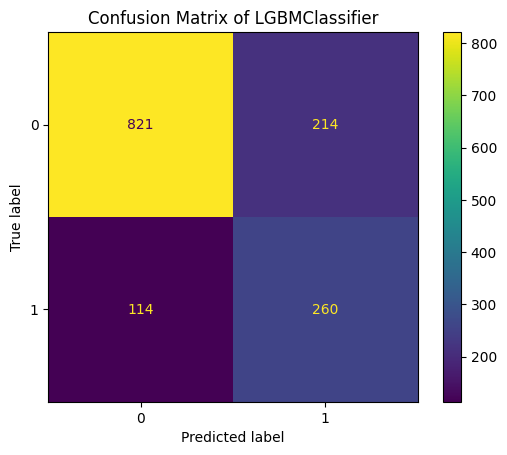

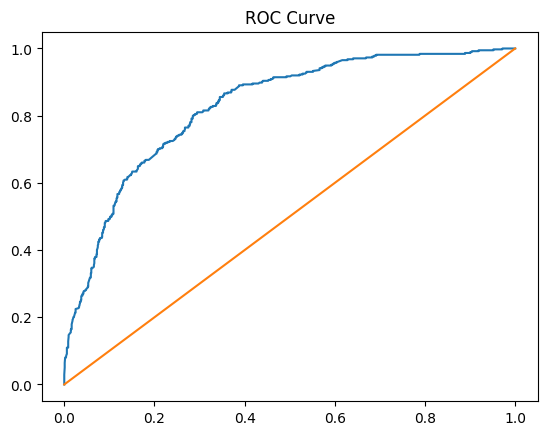

In [88]:
# Data Preparation
# ==============================================
df = df_ori.copy().drop(columns=["Customer ID", "Latitude", "Longitude", "Location", "CLTV (Predicted Thou. IDR)"])  # drop unimportant data
df["Internet Service"] = df.apply(lambda x: check_internet_service(x), axis=1)  # feature engineering
df["Total Purchase"] = df["Tenure Months"] * df["Monthly Purchase (Thou. IDR)"]  # feature engineering
df["Device Class"] = df["Device Class"].replace({"High End": 3, "Mid End": 2, "Low End": 1})  # encode Device Class  
df["Churn Label"] = df["Churn Label"].replace({"Yes": 1, "No": 0})  # encode Churn Label
X, y = pd.get_dummies(df.drop(columns=["Churn Label"]), dtype=int), df["Churn Label"]  # split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)

# Oversampling for balancing dataset
# ==============================================
smote = SMOTE(random_state=42)  # <<<<<<<<<<<<< SMOTE OVERSAMPLING
X_train, y_train = smote.fit_resample(X_train, y_train)  # <<<<<<<<<<<<< SMOTE OVERSAMPLING

# Scale data (tree model don't need for scaling)
# ==============================================
X_train = scaler.fit_transform(X_train)  # <<<<<<<<<<<<< SCALING
X_test = scaler.transform(X_test)  # <<<<<<<<<<<<< SCALING


# Best Param
LGBM_PARAMS = {
    "lambda_l1": 3.294029661328798,
    "lambda_l2": 0.7652261853285929,
    "num_leaves": 3,
    "feature_fraction": 0.9335787001541032,
    "bagging_fraction": 0.458298859099658,
    "bagging_freq": 2,
    "min_child_samples": 50,
    "random_state": 42
}
# Create Best Model
# ==============================================
model = lgb.LGBMClassifier(**LGBM_PARAMS, verbose=-1)
model.fit(X_train, y_train)


# Predict
# ==============================================
y_pred_proba = model.predict_proba(X_test)
y_pred = [1 if prob > 0.5 else 0 for prob in y_pred_proba[:,1]]
evaluate(model, y_test, y_pred, y_pred_proba)

c:\Users\USER\anaconda3\envs\ml-tools\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


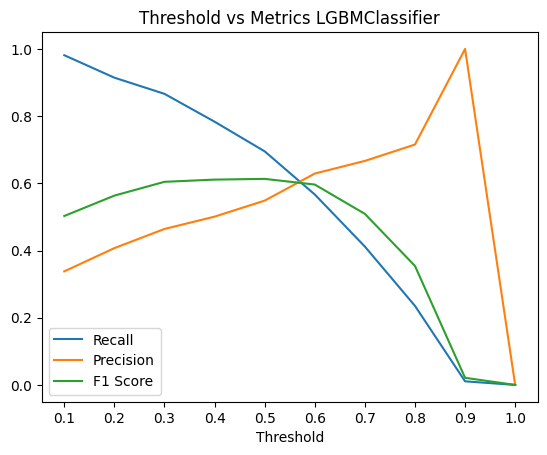

In [86]:
recalls = []
precisions = []
f1s = []
thresholds = np.arange(0.1, 1.1, 0.1)
for threshold in thresholds:
    y_pred_proba = model.predict_proba(X_test)
    y_pred = [1 if prob > threshold else 0 for prob in y_pred_proba[:,1]]
    recalls.append(recall_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred))
    f1s.append(f1_score(y_test, y_pred))
    
pd.DataFrame({
    "Threshold": thresholds,
    "Recall": recalls,
    "Precision": precisions,
    "F1 Score": f1s
}).set_index("Threshold").plot()
plt.title(f"Threshold vs Metrics {model.__class__.__name__}")
plt.xticks(np.arange(0.1, 1.1, 0.1))
plt.show()

Optimal threshold round 0.55


    METRICS
    Accuracy: 0.7849538679914834
    Precision: 0.58679706601467
    Recall: 0.6417112299465241
    F1 Score: 0.6130268199233717
    ROC AUC score: 0.7392131028959673
    Specificity: 0.8367149758454107
    


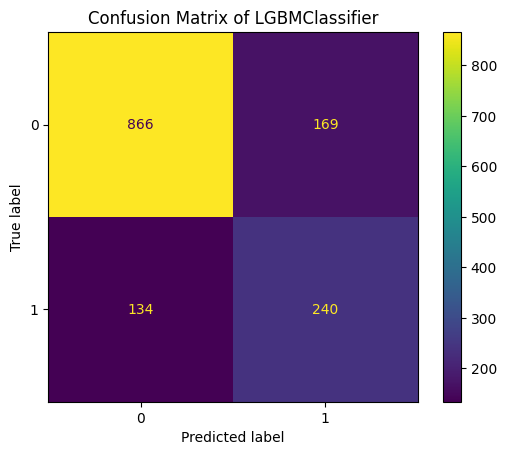

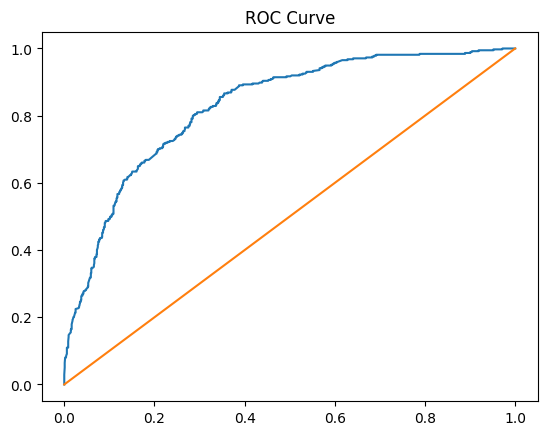

Text(0.5, 1.0, 'Feature Importance')

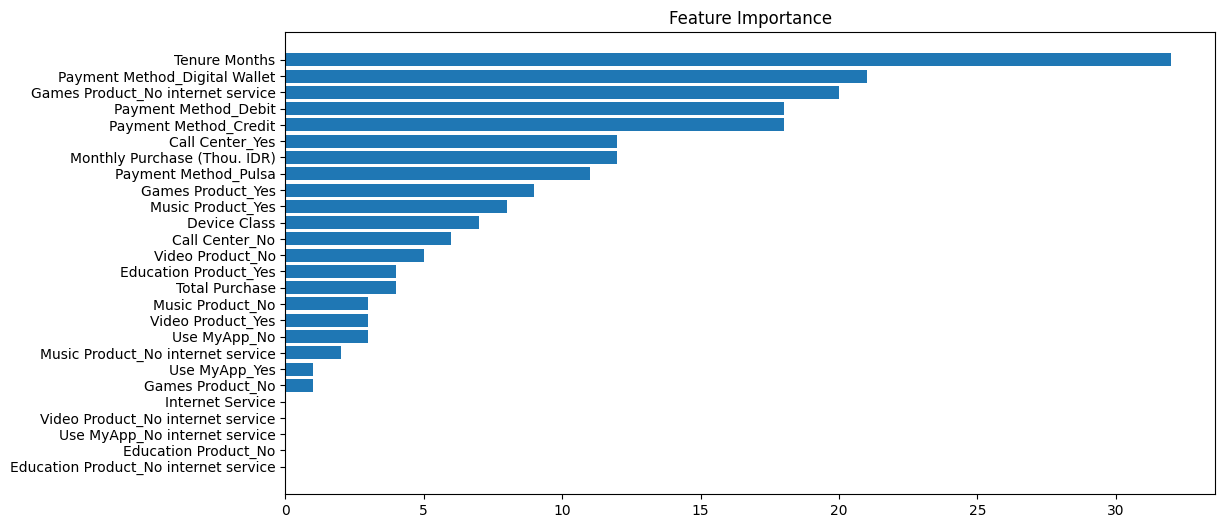

In [87]:
# Predict
# ==============================================
y_pred_proba = model.predict_proba(X_test)
y_pred = [1 if prob > 0.55 else 0 for prob in y_pred_proba[:,1]]
evaluate(model, y_test, y_pred, y_pred_proba)

feature_importances = model.feature_importances_
sorted_idx = np.argsort(feature_importances)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.title('Feature Importance')


c:\Users\USER\anaconda3\envs\ml-tools\lib\site-packages\seaborn\categorical.py:3370: UserWarning: 10.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


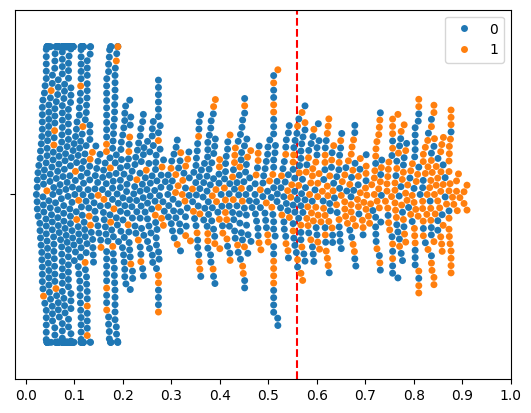

In [82]:
# swarmplot
sns.swarmplot(x=y_pred_proba[:, 1], hue=y_test.tolist())
plt.axvline(0.56, label="Threshold", color="red", linestyle="--")
plt.xticks(np.arange(0, 1.001, 0.1))
plt.show()

# Reconsideration
When it comes to presenting the results to the management, they want to be able to target actual churned customers that has high CLTV, but at the same time they don't want to spent more money on those who aren't actually churned. So from the management perspective they want: as much as high CLTV churned customers.

In [115]:
pair_model_params = [
    (RandomForestClassifier, {
    "max_depth": 9,
    "min_samples_split": 200,
    "min_samples_leaf": 200,
    "n_estimators": 900,
    "max_samples": 0.5,
    "max_features": 13,
    "random_state": 42
}),
    (cb.CatBoostClassifier, {
    "objective": "Logloss",
    "colsample_bylevel": 0.02590386849886261,
    "depth": 11,
    "boosting_type": "Plain",
    "bootstrap_type": "Bayesian",
    "bagging_temperature": 9.911079288875817,
    "random_state": 42
}),
    (xgb.XGBClassifier, {
    "booster": "gbtree",
    "lambda": 9.512181414997377e-06,
    "alpha": 6.725796559624205e-07,
    "subsample": 0.7851877267962145,
    "colsample_bytree": 0.3511400455357884,
    "max_depth": 7,
    "min_child_weight": 5,
    "eta": 8.276692831028129e-05,
    "gamma": 4.674781697510346e-07,
    "grow_policy": "lossguide",
    "random_state": 42
}),
    (lgb.LGBMClassifier, {
    "lambda_l1": 3.294029661328798,
    "lambda_l2": 0.7652261853285929,
    "num_leaves": 3,
    "feature_fraction": 0.9335787001541032,
    "bagging_fraction": 0.458298859099658,
    "bagging_freq": 2,
    "min_child_samples": 50,
    "random_state": 42
})
]

In [119]:
# Data Preparation
# ==============================================
df = df_ori.copy().drop(columns=["Customer ID", "Latitude", "Longitude", "Location", "CLTV (Predicted Thou. IDR)"])  # drop unimportant data
df["Internet Service"] = df.apply(lambda x: check_internet_service(x), axis=1)  # feature engineering
df["Total Purchase"] = df["Tenure Months"] * df["Monthly Purchase (Thou. IDR)"]  # feature engineering
df["Device Class"] = df["Device Class"].replace({"High End": 3, "Mid End": 2, "Low End": 1})  # encode Device Class  
df["Churn Label"] = df["Churn Label"].replace({"Yes": 1, "No": 0})  # encode Churn Label
X, y = pd.get_dummies(df.drop(columns=["Churn Label"]), dtype=int), df["Churn Label"]  # split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)
test_index = X_test.index

# Oversampling for balancing dataset
# ==============================================
smote = SMOTE(random_state=42)  # <<<<<<<<<<<<< SMOTE OVERSAMPLING
X_train, y_train = smote.fit_resample(X_train, y_train)  # <<<<<<<<<<<<< SMOTE OVERSAMPLING

# Scale data (tree model don't need for scaling)
# ==============================================
X_train = scaler.fit_transform(X_train)  # <<<<<<<<<<<<< SCALING
X_test = scaler.transform(X_test)  # <<<<<<<<<<<<< SCALING

models = []
cltvs = []
for (model, params) in pair_model_params:
    # Create Best Model
    # ==============================================
    model = model(**params)
    model.fit(X_train, y_train)

    # Predict using threshold 0.5
    # ==============================================
    y_pred_proba = model.predict_proba(X_test)
    y_pred = [1 if prob > 0.55 else 0 for prob in y_pred_proba[:,1]]

    # Calculate CLTV
    # ==============================================
    df = df_ori.copy()
    potentially_saved_money = df.iloc[(y_pred == y_test).index, -1].sum()
    models.append(model.__class__.__name__)
    cltvs.append(potentially_saved_money)
    
pd.DataFrame({    
    "Model": models,
    "CLTV": cltvs
    })

Learning rate set to 0.025403
0:	learn: 0.6931335	total: 1.19ms	remaining: 1.19s
1:	learn: 0.6922376	total: 2.67ms	remaining: 1.33s
2:	learn: 0.6922491	total: 3.95ms	remaining: 1.31s
3:	learn: 0.6922476	total: 5.38ms	remaining: 1.34s
4:	learn: 0.6922495	total: 6.55ms	remaining: 1.3s
5:	learn: 0.6922495	total: 7.8ms	remaining: 1.29s
6:	learn: 0.6922487	total: 9.08ms	remaining: 1.29s
7:	learn: 0.6893273	total: 10.8ms	remaining: 1.33s
8:	learn: 0.6893243	total: 12.1ms	remaining: 1.33s
9:	learn: 0.6823072	total: 14.1ms	remaining: 1.4s
10:	learn: 0.6803343	total: 15.7ms	remaining: 1.41s
11:	learn: 0.6777655	total: 17.5ms	remaining: 1.44s
12:	learn: 0.6775048	total: 19ms	remaining: 1.44s
13:	learn: 0.6775055	total: 20.3ms	remaining: 1.43s
14:	learn: 0.6775054	total: 21.5ms	remaining: 1.41s
15:	learn: 0.6726055	total: 23.3ms	remaining: 1.43s
16:	learn: 0.6726054	total: 24.8ms	remaining: 1.43s
17:	learn: 0.6726052	total: 26.2ms	remaining: 1.43s
18:	learn: 0.6716993	total: 27.8ms	remaining: 1.4

,Model,CLTV
0,RandomForestClassifier,8032154.0
1,CatBoostClassifier,8032154.0
2,XGBClassifier,8032154.0
3,LGBMClassifier,8032154.0
